In [1]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

/root/code_Bao/Vietnamese_stocks_forecasting/notebook


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import stumpy
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import numpy.testing as npt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from vnstock import * #import all functions

# Utils

Here I want to use stock data of Vietnamses stocks (VNINDEX)

In [3]:
current_date = datetime.now().strftime('%Y-%m-%d')

In [4]:
try:
    # Attempt to get historical data with the given end_date
    vni_df = stock_historical_data("VNINDEX", "2007-01-01", current_date, "1D", "index")
except Exception as e:
    # If there's an error, subtract one day from the end_date and try again
    print(f"Error occurred: {e}")
    current_date = (datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=1)).strftime('%Y-%m-%d')
    vni_df = stock_historical_data("VNINDEX", "2007-01-01", current_date, "1D", "index")
print (current_date) 

2023-11-04


In [5]:
vni_df.head()

time    open    high     low   close     volume   ticker
0  2020-05-11  818260  828330  812480  828330  353416000  VNINDEX
1  2020-05-13  835320  839590  815130  834210  374602816  VNINDEX
2  2020-05-15  835420  838470  824590  827030  301891136  VNINDEX
3  2020-05-18  827490  827900  823230  823230   29758024  VNINDEX
4  2020-05-19  852140  854250  844150  845920  385271840  VNINDEX

In [6]:
def create_pct_col(dataframe, pct_cols = []):
    new_df = dataframe.copy()
    for col in pct_cols:
        pct_col_name = f"{col}_pct"  
        new_df[pct_col_name] = new_df[col].pct_change()
        new_df[pct_col_name].replace([np.inf, -np.inf], np.nan, inplace=True)
    return new_df

In [7]:
vni_df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'ticker'], dtype='object')

In [8]:
time_cols = ['time']
float_cols = ['open', 'high', 'low', 'close', 'volume']
cat_cols = ['ticker']

STUMPY uses float datatype as input

In [9]:
def convert_data_type(df, time_cols=[], float_cols = [], cat_cols = []):
    for col in time_cols:
        df[col] = pd.to_datetime(df[col], yearfirst = True)
    for col in float_cols:
        df[col] = df[col].astype(float)
    for col in cat_cols:
        df[col] = df[col].astype('category')
    return df

In [10]:
vni_df = convert_data_type(vni_df, time_cols, float_cols, cat_cols)

In [11]:
vni_new = create_pct_col(vni_df, pct_cols = ['close', 'volume'])
vni_new.head()

time      open      high       low     close       volume   ticker  \
0 2020-05-11  818260.0  828330.0  812480.0  828330.0  353416000.0  VNINDEX   
1 2020-05-13  835320.0  839590.0  815130.0  834210.0  374602816.0  VNINDEX   
2 2020-05-15  835420.0  838470.0  824590.0  827030.0  301891136.0  VNINDEX   
3 2020-05-18  827490.0  827900.0  823230.0  823230.0   29758024.0  VNINDEX   
4 2020-05-19  852140.0  854250.0  844150.0  845920.0  385271840.0  VNINDEX   

   close_pct  volume_pct  
0        NaN         NaN  
1   0.007099    0.059949  
2  -0.008607   -0.194103  
3  -0.004595   -0.901428  
4   0.027562   11.946822

In [12]:
vni_close = vni_df[['close', 'open']]
vni_close.head()

close      open
0  828330.0  818260.0
1  834210.0  835320.0
2  827030.0  835420.0
3  823230.0  827490.0
4  845920.0  852140.0

In [13]:
def format_date_from_idx(df, start_index:int, m:int):
    '''
    Create start_date and end_date from start index of dataframe and window size
    m: window size
    output: (str): '%Y-%m-%d'
    '''
    start_date_timestamp = df.iloc[start_index]
    end_date_timestamp = df.iloc[start_index + m - 1]

    # Format start date and end date in the same format as input
    formatted_start_date = start_date_timestamp.strftime('%Y-%m-%d')
    formatted_end_date = end_date_timestamp.strftime('%Y-%m-%d')
    return formatted_start_date,formatted_end_date

This is simple function to find_similar_subseries_with_date. The original tutorial from STUMPY will find the best pairs. However, I will modify it a lil bit for my use

In [14]:
def find_similar_subseries_with_date(stock_data, 
                           start_date:str = '2023-06-30', end_date:str = '2023-10-15',
                           time_col:str = 'time',
                           price_col:str = 'close'
                          ):
    # Convert the time column to datetime objects
    stock_data[time_col] = pd.to_datetime(stock_data[time_col], yearfirst = True)
    
    # Filter DataFrame based on input dates using pandas
    filtered_data = stock_data[(stock_data[time_col] >= start_date) & (stock_data[time_col] <= end_date)]
    
    # Extract the subseries you want to find
    subseries_to_find = filtered_data[price_col].values

    # Compute the matrix profile using stumpy for the full time series
    matrix_profile = stumpy.stump(stock_data[price_col], m=len(subseries_to_find))
    
    start_date_index = np.where(stock_data[time_col] == pd.to_datetime(start_date))[0][0]

    # Find the index of the most similar subsequence
    motif_index = matrix_profile[start_date_index, 1]
    print (f'The distance score is {matrix_profile[start_date_index, 0]}')

    # Extract the similar subsequence from the full time series
    similar_subsequence = stock_data[price_col].iloc[motif_index:motif_index + len(subseries_to_find)].values
    
    formatted_start_date,formatted_end_date = format_date_from_idx(df = stock_data[time_col],
                                                                  start_index = motif_index,
                                                                  m = len(subseries_to_find))
    
    # Print the indices of the similar subsequence in the full time series and formatted dates
    print(f'Similar Subsequence from {start_date} to {end_date} (Indices: {formatted_start_date} to {formatted_end_date})')
    return formatted_start_date, formatted_end_date


In [15]:
vni_close = vni_df[['time','close']]
vni_close.head()

time     close
0 2020-05-11  828330.0
1 2020-05-13  834210.0
2 2020-05-15  827030.0
3 2020-05-18  823230.0
4 2020-05-19  845920.0

# find_similar_subseries_with_date

In [16]:
# Example usage
start_date = '2023-06-30'
end_date = '2023-10-15'
sim_start_date, sim_end_date = find_similar_subseries_with_date(vni_close, start_date, end_date)

/tmp/ipykernel_5348/2975123134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data[time_col] = pd.to_datetime(stock_data[time_col], yearfirst = True)


The distance score is 5.992122632149476
Similar Subsequence from 2023-06-30 to 2023-10-15 (Indices: 2022-07-05 to 2022-10-18)


In [17]:
def draw_time_series(stock_data, start_date:str = '2023-06-30', end_date:str = '2023-10-15', 
                    time_col:str = 'time',
                   price_col:str = 'close',
                     title:str = "The original",):    
    # Filter DataFrame based on input dates
    filtered_data = stock_data[(stock_data[time_col] >= start_date) & (stock_data[time_col] <= end_date)]
    
    # Extract data for plotting
    dates = filtered_data[time_col]
    close_prices = filtered_data[price_col]
    
    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(dates, close_prices, marker='o', linestyle='-', color='b')
    plt.title(f'Time Series from {start_date} to {end_date}')
    plt.xlabel(time_col)
    plt.ylabel(price_col)
    plt.grid(True)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

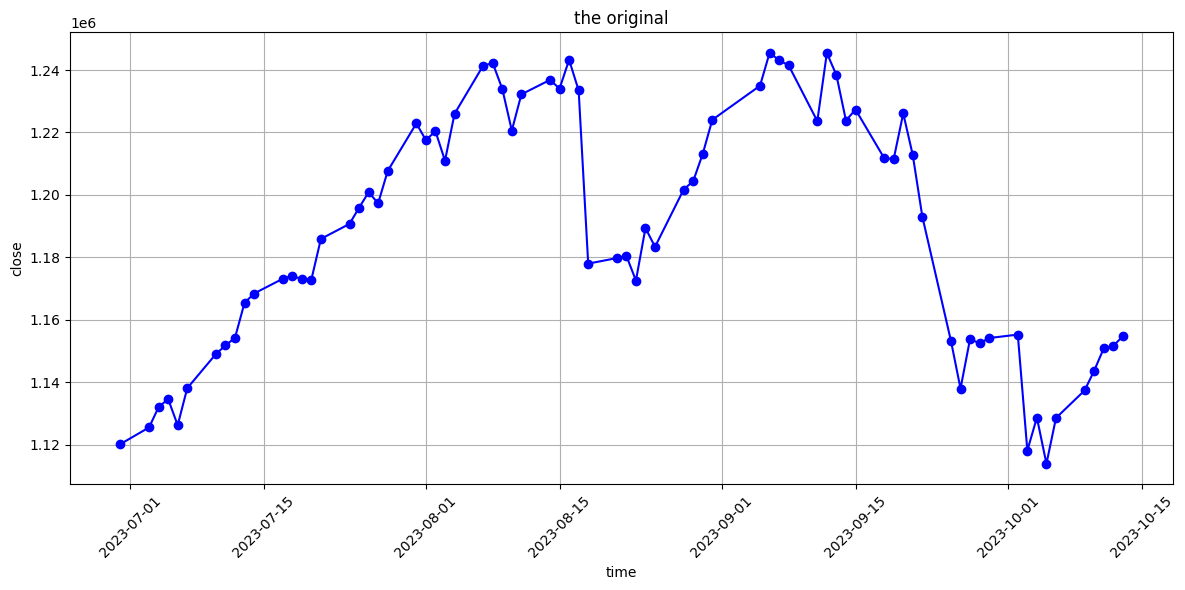

In [18]:
draw_time_series(vni_close, start_date, end_date, title = "the original")

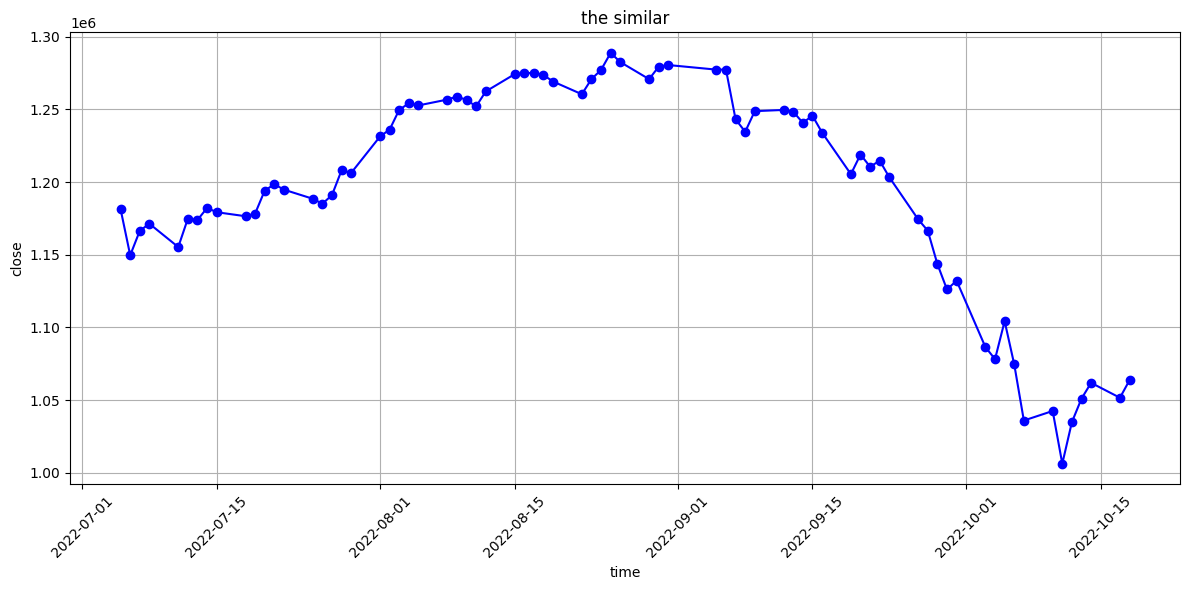

In [19]:
draw_time_series(vni_close, sim_start_date, sim_end_date, title = "the similar")

In [20]:
def find_matching_series_pattern(stock_data, start_date='2023-06-30', end_date='2023-10-15', 
                                 time_col='time', price_col='close', k=3):
    # Filter DataFrame based on input dates
    filtered_data = stock_data[(stock_data[time_col] >= start_date) & (stock_data[time_col] <= end_date)]  
    Q_df = filtered_data[price_col]
    T_df = stock_data[price_col]
    distance_profile = stumpy.match(Q_df, T_df)
    k_index = distance_profile[:k, 1]
    
    print(f'Top {len(k_index)} similar periods')
    for i, idx in enumerate(k_index):
        formatted_start_date,formatted_end_date = format_date_from_idx(df = stock_data[time_col],
                                                                      start_index = idx,
                                                                      m = len(Q_df))
        distance = distance_profile[i, 0]
        print(f'From {formatted_start_date} to {formatted_end_date}: Distance = {distance}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(T_df.values)
    for idx in k_index:
        plt.plot(range(idx, idx+len(Q_df)), T_df.values[idx:idx+len(Q_df)], lw=2, label=f'Series at index {idx}')
    
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

# find_matching_series_pattern top periods
Now I want to find the top k pairs for further use

Top 4 similar periods
From 2023-06-30 to 2023-10-13: Distance = 3.866844151973494e-06
From 2022-07-05 to 2022-10-18: Distance = 5.992122632149494
From 2022-01-13 to 2022-05-06: Distance = 7.033234485539716
From 2021-04-16 to 2021-08-06: Distance = 7.264112029114285


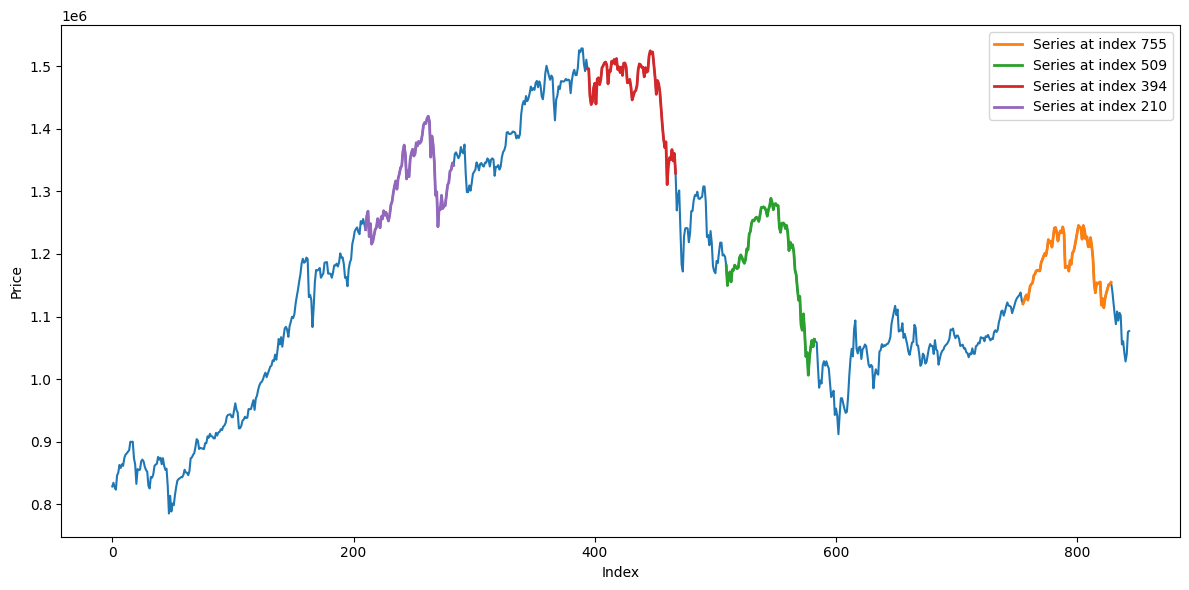

In [21]:
find_matching_series_pattern(vni_close, k=6)

In [22]:
vni_df['volume'] = vni_df['volume'].astype(float)

Also find pattern in volume

Top 5 similar periods
From 2023-06-30 to 2023-10-13: Distance = 7.363646686438224e-07
From 2021-10-15 to 2022-01-27: Distance = 8.305352896633815
From 2022-11-01 to 2023-02-20: Distance = 8.722215149331655
From 2022-01-21 to 2022-05-16: Distance = 9.028898237984107
From 2022-09-28 to 2023-01-10: Distance = 9.089728063937045


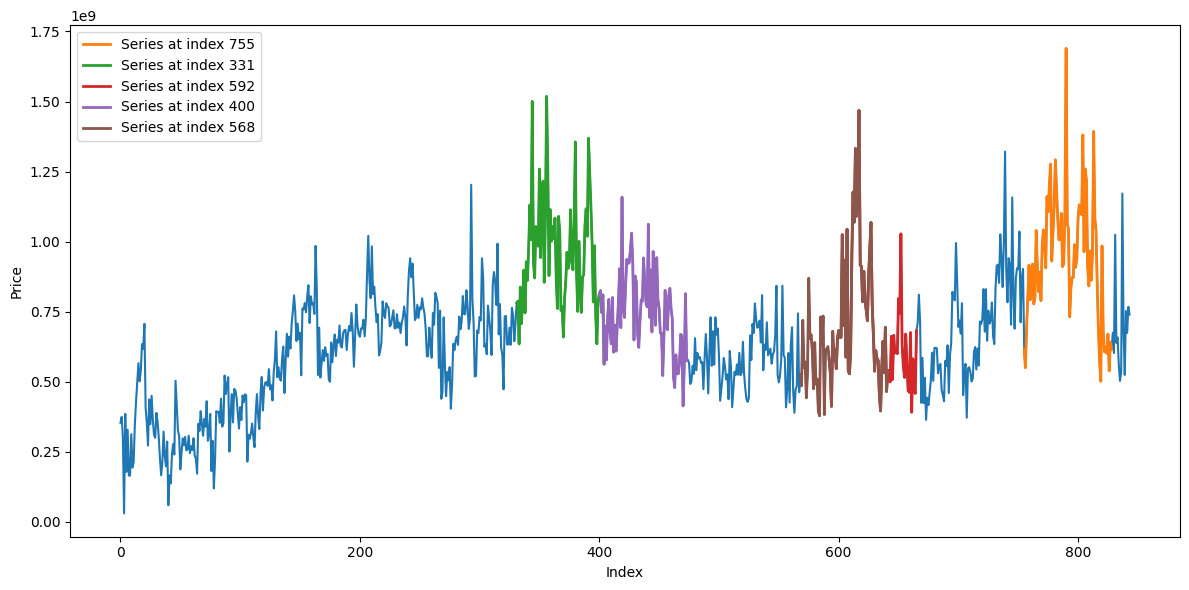

In [23]:
find_matching_series_pattern(vni_df[['time','volume']],price_col ='volume', k=19)

In [24]:
def find_matching_series_multi_dim_with_date (stock_data, 
                                              start_date='2023-06-30', end_date='2023-10-15', 
                                             time_col='time',
                                             dimension_cols = ['close','volume']):
    
    start_date_index = np.where(stock_data[time_col] == pd.to_datetime(start_date))[0][0]
    end_date_index = np.where(stock_data[time_col] == pd.to_datetime(end_date))[0][0]
    m = end_date_index - start_date_index
    df = stock_data[dimension_cols]
    mps, indices = stumpy.mstump(df, m)
    start_date_index = np.repeat(start_date_index, len(df.columns))
    nn_idx = indices[np.arange(len(df.columns)), start_date_index]
    
    fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14, 3 * mps.shape[0] * 2))

    for k, dim_name in enumerate(df.columns):
        axs[k].set_ylabel(dim_name, fontsize='20')
        axs[k].plot(df[dim_name])
        axs[k].set_xlabel('Time', fontsize ='20')

        axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
        axs[k + mps.shape[0]].plot(mps[k], c='orange')
        axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

        axs[k].axvline(x=start_date_index[1], linestyle="dashed", c='black')
        axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
        axs[k + mps.shape[0]].axvline(x=start_date_index[1], linestyle="dashed", c='black')
        axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

        axs[k].plot(range(start_date_index[k], start_date_index[k] + m), df[dim_name].iloc[start_date_index[k] : start_date_index[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(start_date_index[k], mps[k, start_date_index[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')

    plt.tight_layout()
    plt.show()


# find_matching_series_multi_dimension
This code is to find the pattern in multiple dimensions at the same time, Now I use both close price and volume

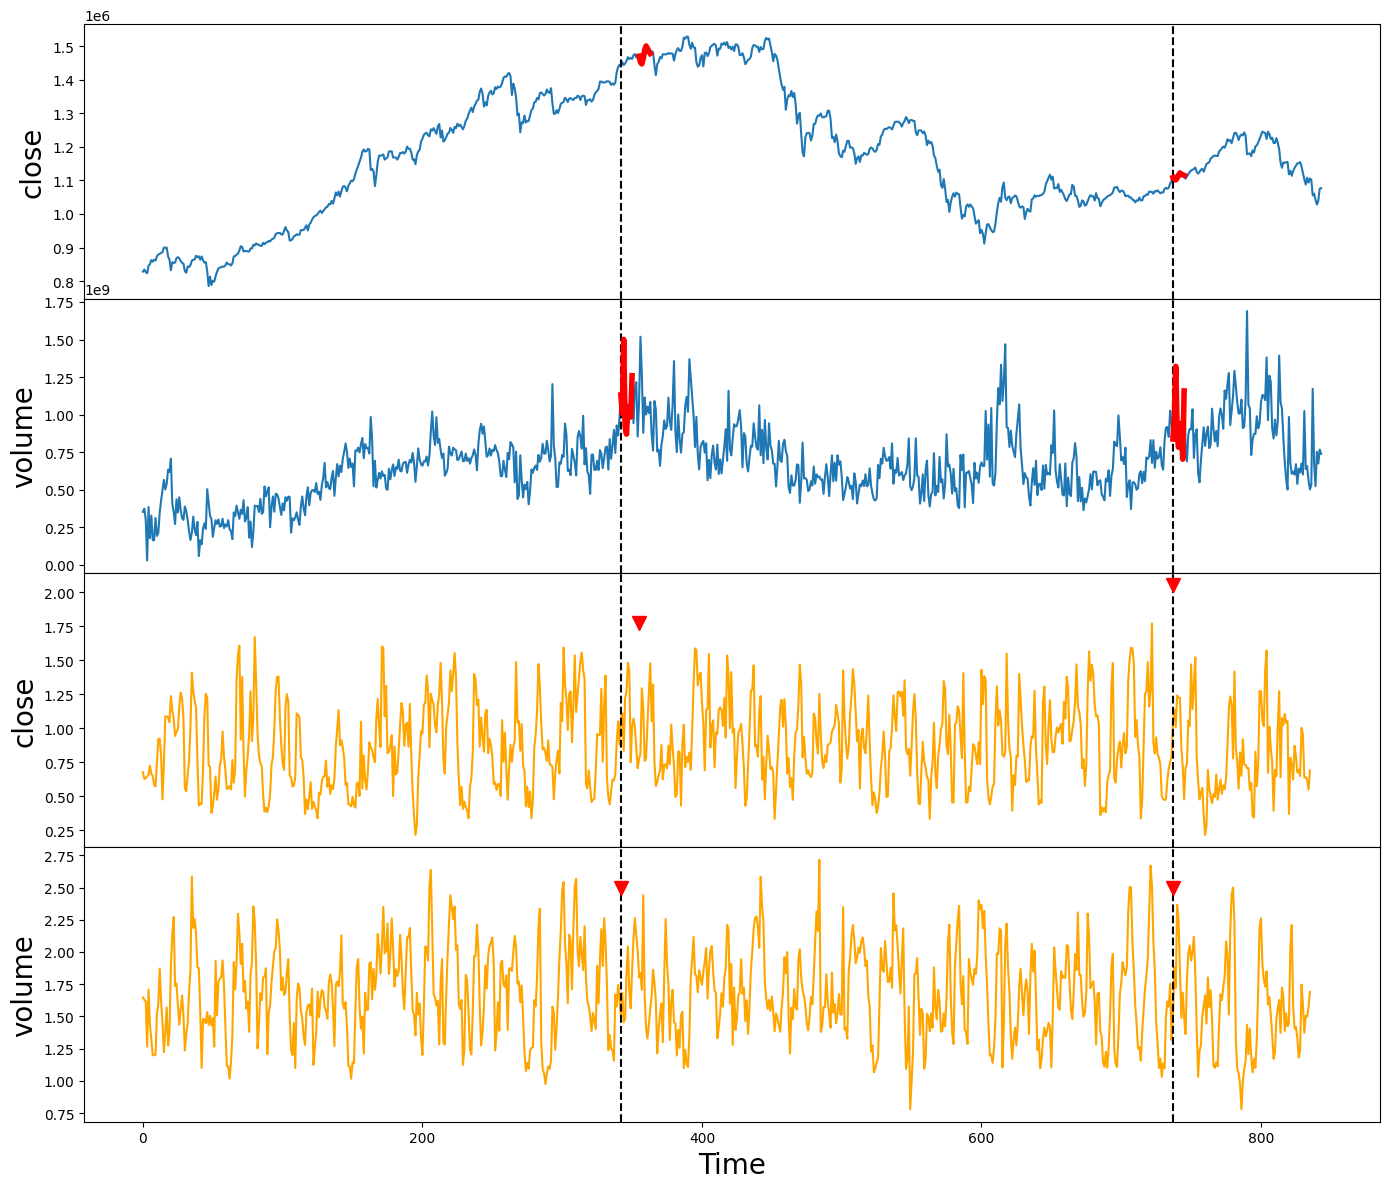

In [25]:
find_matching_series_multi_dim_with_date (vni_df, start_date='2023-06-06', end_date='2023-06-19')

In [26]:
vni_new.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'ticker', 'close_pct',
       'volume_pct'],
      dtype='object')

In [27]:
vni_new.head()

time      open      high       low     close       volume   ticker  \
0 2020-05-11  818260.0  828330.0  812480.0  828330.0  353416000.0  VNINDEX   
1 2020-05-13  835320.0  839590.0  815130.0  834210.0  374602816.0  VNINDEX   
2 2020-05-15  835420.0  838470.0  824590.0  827030.0  301891136.0  VNINDEX   
3 2020-05-18  827490.0  827900.0  823230.0  823230.0   29758024.0  VNINDEX   
4 2020-05-19  852140.0  854250.0  844150.0  845920.0  385271840.0  VNINDEX   

   close_pct  volume_pct  
0        NaN         NaN  
1   0.007099    0.059949  
2  -0.008607   -0.194103  
3  -0.004595   -0.901428  
4   0.027562   11.946822

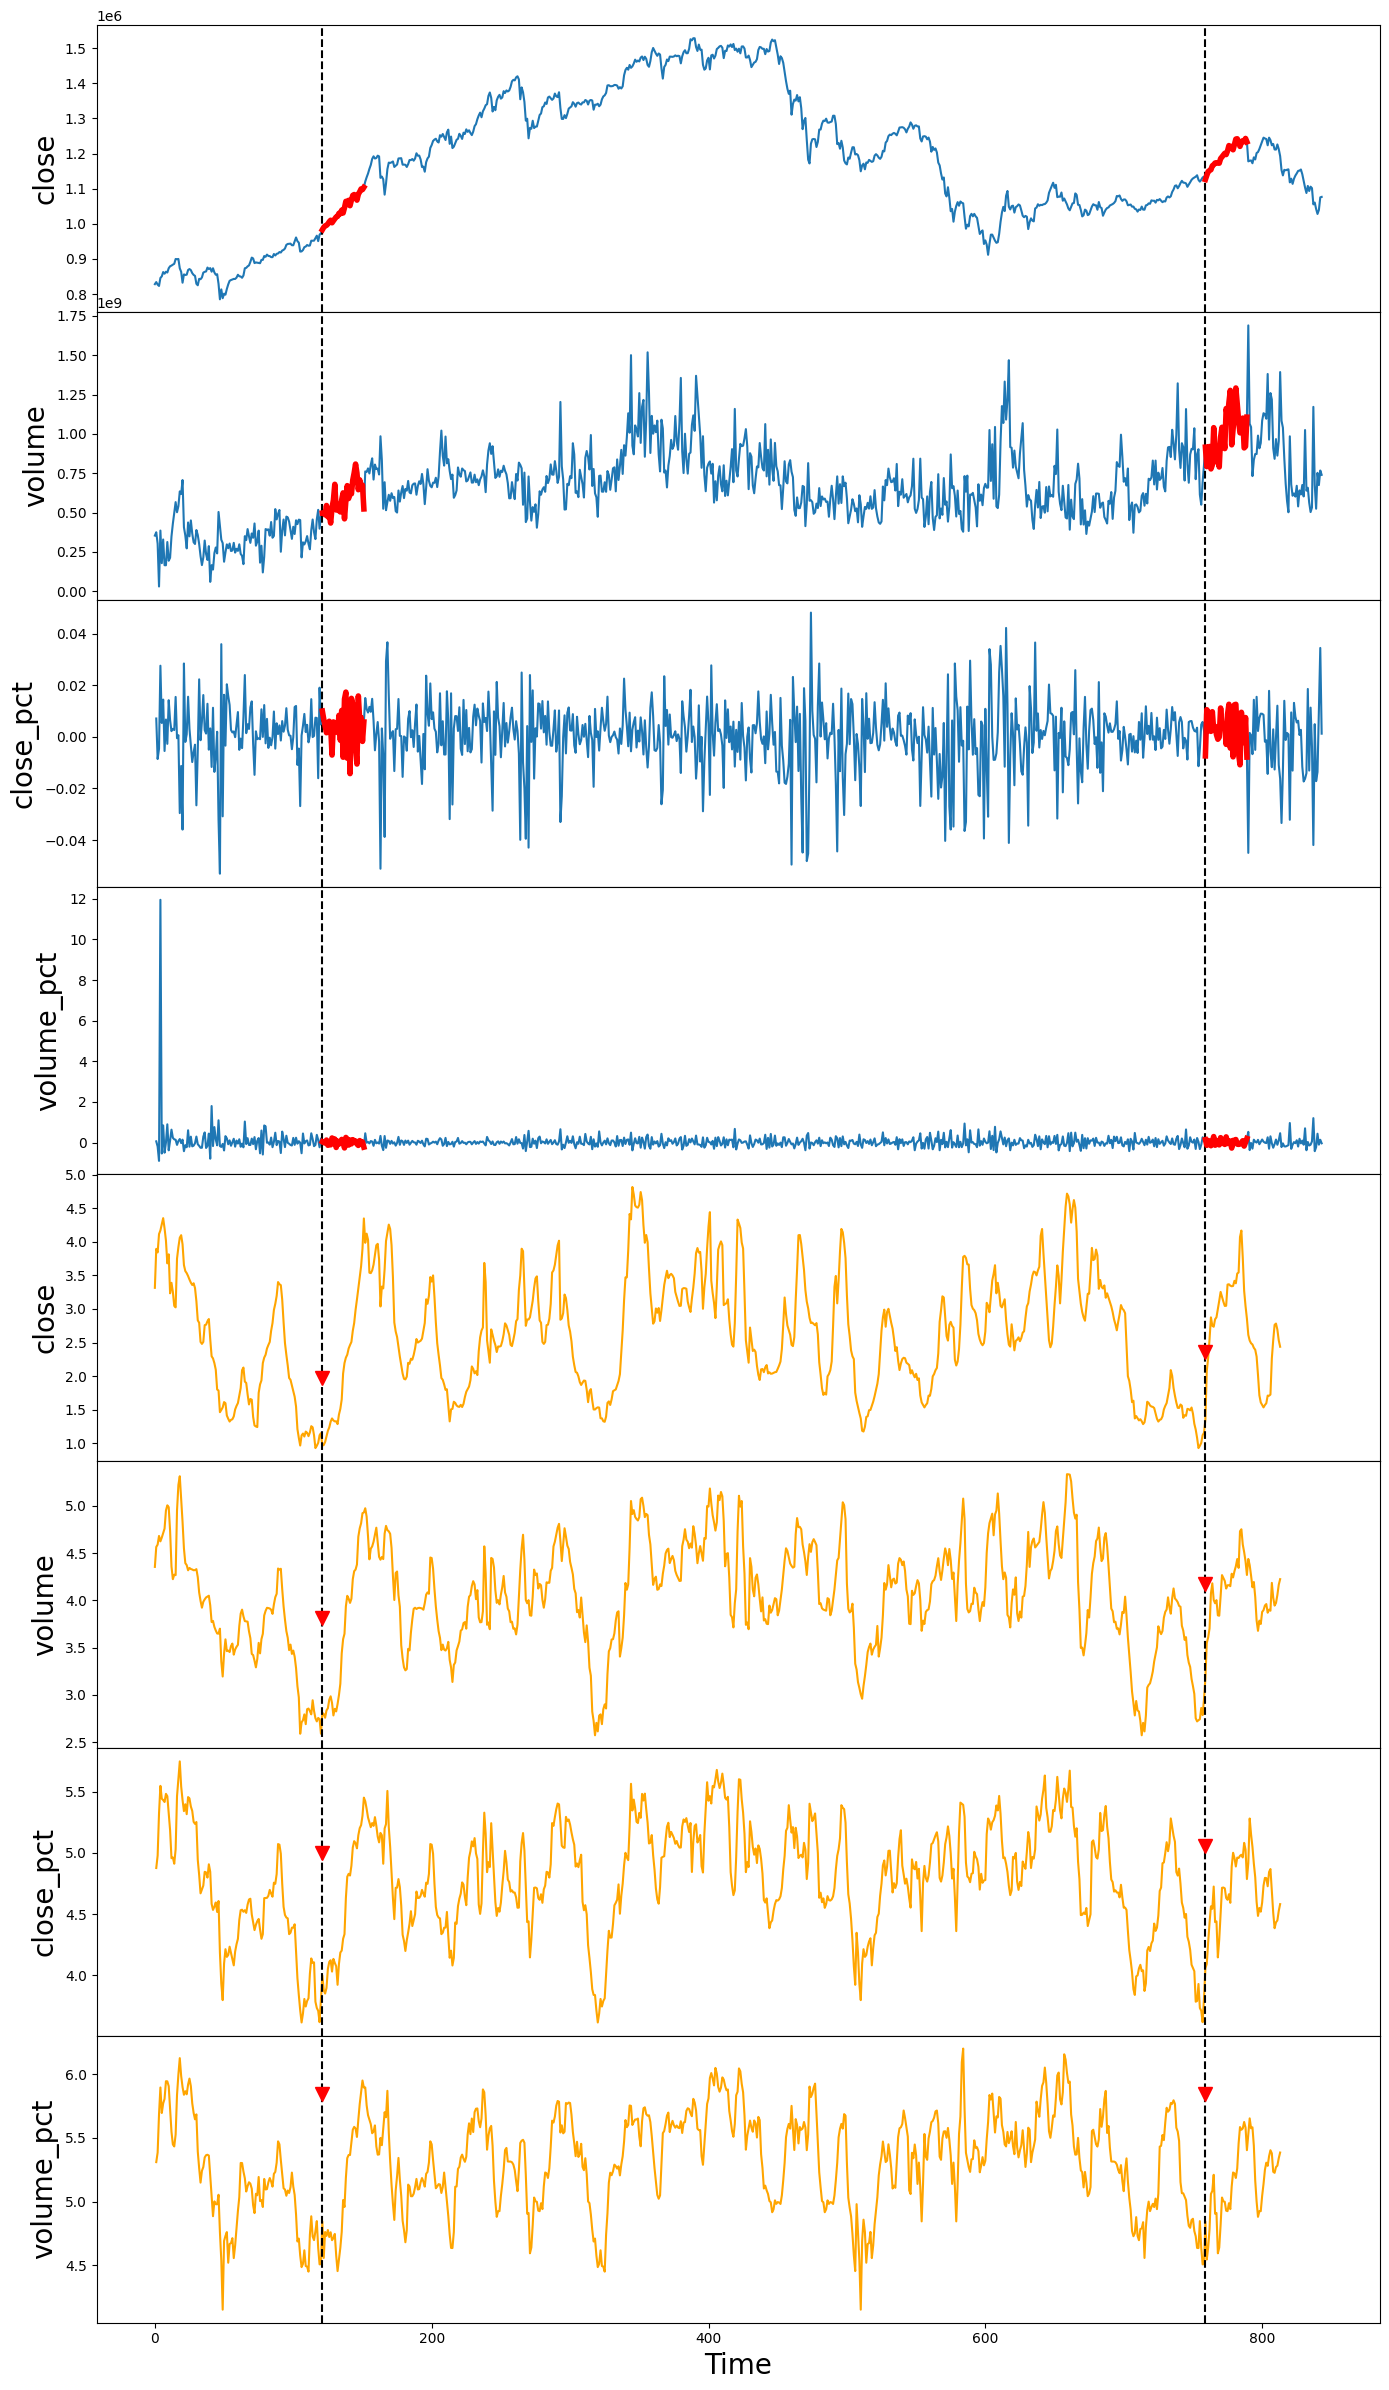

In [28]:
find_matching_series_multi_dim_with_date (vni_new, start_date='2023-07-06', end_date='2023-08-18',
                                         dimension_cols = ['close','volume', 'close_pct','volume_pct'])

This code is especially useful when you want to loop for m -  window size to find best pairs

In [29]:
def find_matching_series_multi_dim_with_m (stock_data, m:int = 30,
                                             time_col='time',
                                          dimension_cols = ['close','volume']):
    df = stock_data[dimension_cols]
    mps, indices = stumpy.mstump(df, m)
    motifs_idx = np.argmin(mps, axis=1)
    nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

    fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14, 3 * mps.shape[0] * 2))

    for k, dim_name in enumerate(df.columns):
        axs[k].set_ylabel(dim_name, fontsize='20')
        axs[k].plot(df[dim_name])
        axs[k].set_xlabel('Time', fontsize ='20')

        axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
        axs[k + mps.shape[0]].plot(mps[k], c='orange')
        axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

        axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
        axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

        axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')

    plt.tight_layout()
    plt.show()


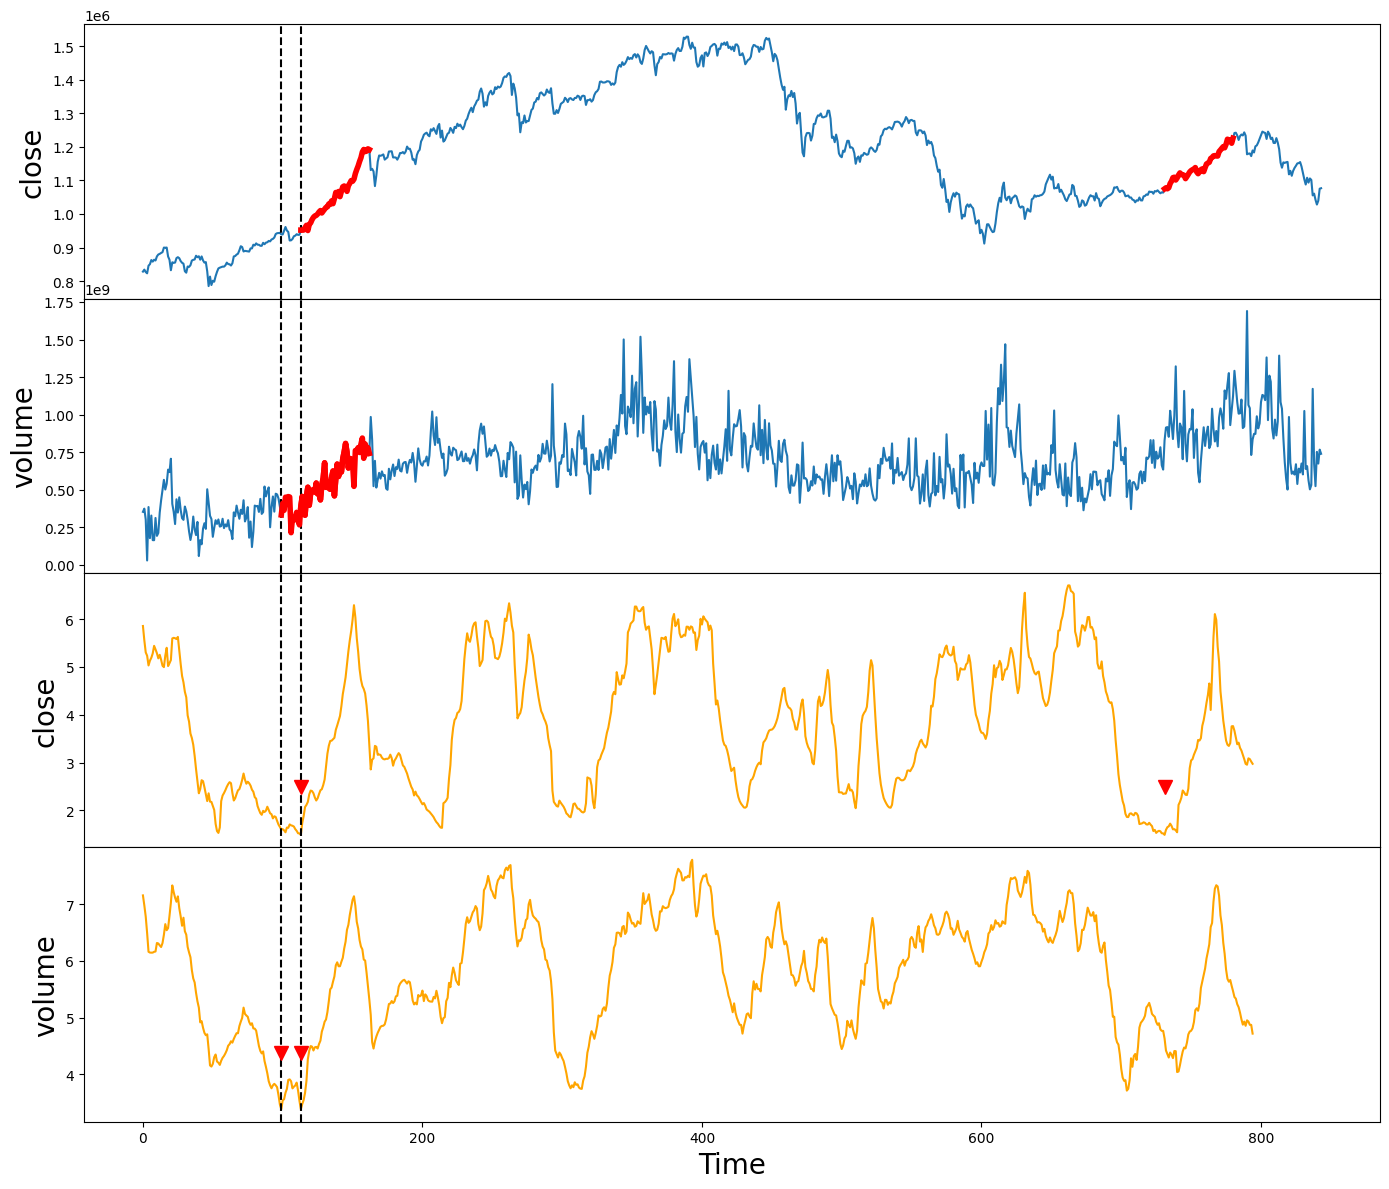

In [30]:
find_matching_series_multi_dim_with_m(vni_df, m = 50,)

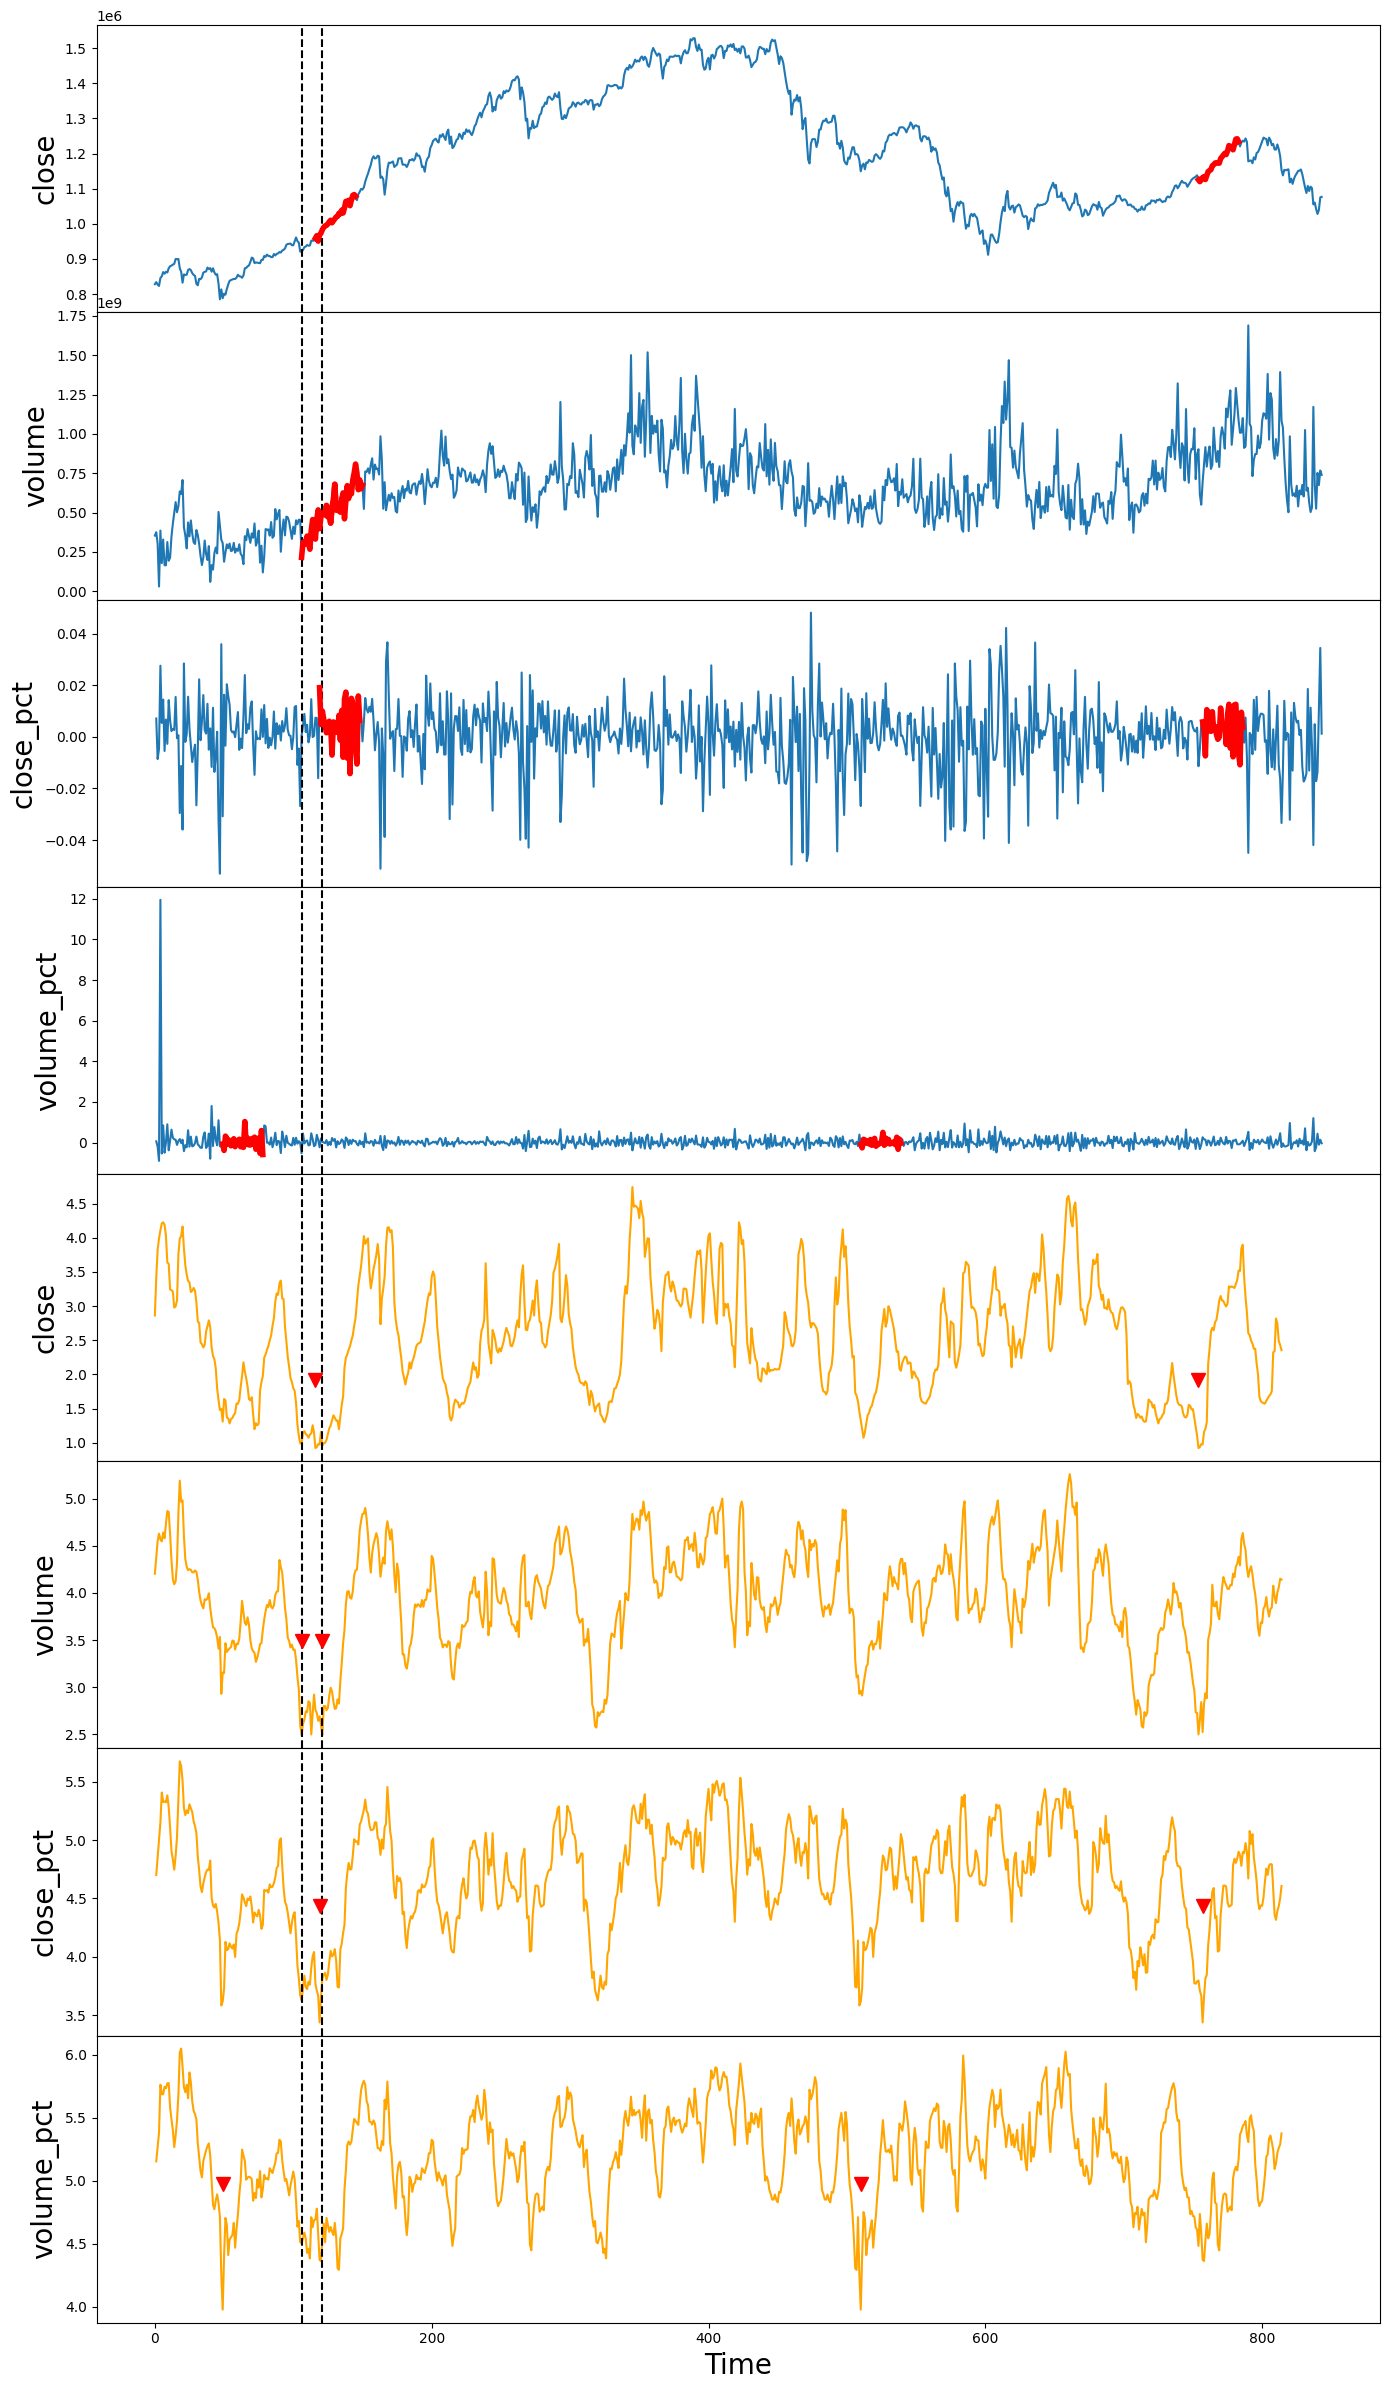

In [31]:
find_matching_series_multi_dim_with_m(vni_new, m = 30,
                                      dimension_cols = ['close','volume', 'close_pct','volume_pct'])

# Filter similar patterns in other stocks

The pattern we want to check

In [32]:
start_date = "2023-07-30"
vni_df = stock_historical_data("VNINDEX", start_date , current_date, "1D", "index")
vni_df = convert_data_type(vni_df, time_cols, float_cols, cat_cols)
vni_df.head()

time       open       high        low      close        volume  \
0 2023-07-31  1207670.0  1224810.0  1207670.0  1222900.0  1.199655e+09   
1 2023-08-01  1230320.0  1234500.0  1217560.0  1217560.0  1.276467e+09   
2 2023-08-02  1217030.0  1223040.0  1213180.0  1220430.0  9.303828e+08   
3 2023-08-03  1219730.0  1222350.0  1209060.0  1210950.0  1.029956e+09   
4 2023-08-04  1211900.0  1228120.0  1211900.0  1225980.0  1.124417e+09   

    ticker  
0  VNINDEX  
1  VNINDEX  
2  VNINDEX  
3  VNINDEX  
4  VNINDEX

Filter all the blue chip stocks on HOSE. I think big stocks will the same behavior

In [33]:
params = {
            "exchangeName": "HOSE",
            "marketCap": (10_000, 100_000),
        }

In [34]:
company_list = stock_screening_insights(params, size=1700, drop_lang='vi')['ticker'].tolist()

In [35]:
df = pd.DataFrame()
# Iterate over the company list and add the historical data for each company to the DataFrame
for company in company_list:
    df = pd.concat([df, stock_historical_data(company, "2016-01-01", start_date, "1D", "stock")], axis=0)

# Print the head of the DataFrame
df = convert_data_type(df, time_cols, float_cols, cat_cols)
df.head()

time    open    high     low   close   volume ticker
0 2016-01-04  4480.0  4480.0  4430.0  4450.0  36439.0    ACB
1 2016-01-05  4430.0  4430.0  4360.0  4390.0  47676.0    ACB
2 2016-01-06  4390.0  4410.0  4360.0  4410.0  40589.0    ACB
3 2016-01-07  4360.0  4390.0  4290.0  4320.0  94027.0    ACB
4 2016-01-08  4290.0  4320.0  4290.0  4320.0  84809.0    ACB

Now I want to find the similar pattern of vnindex on other stocks

In [36]:
def find_pattern_within_market(pattern_df, market_df, compare_col = 'close'):
    m = len(vni_df)
    print (f'The length of Pattern: m = {m}')
    market_df =  market_df.groupby('ticker').apply(lambda x: x.sort_values('time')).reset_index(drop=True)
    mp = stumpy.stump(T_A = pattern_df[compare_col],
                        m = m,
                        T_B = market_df[compare_col],
                        ignore_trivial = False,)
    pattern_motif_index = mp[:, 0].argmin()
    market_motif_index = mp[pattern_motif_index, 1]
    result = market_df.iloc[market_motif_index]
    print(f'The motif is located at index {market_motif_index} of "market_df"')
    print(f'The similar pattern is in stock {result["ticker"]} on {result["time"]}')
    return market_motif_index

In [37]:
def draw_pattern_and_stock(pattern_df, market_df, motif_index, figsize=(12, 6)):
    # Create a figure and a set of subplots with two y-axes
    result = market_df.iloc[motif_index]
    fig, ax1 = plt.subplots(figsize = figsize)

    # Plot data from vni_df on the first y-axis
    ax1.set_xlabel('Time')
    ax1.set_ylabel('pattern_df', color='tab:blue')
    ax1.plot(pattern_df['close'].values, color='tab:blue', label='pattern_df')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis to plot data from df
    ax2 = ax1.twinx()
    ax2.set_ylabel('market_df', color='tab:orange')
    ax2.plot(market_df['close'].iloc[motif_index: motif_index + len(pattern_df)].values, color='tab:orange', label='market_df')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Show legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f'The most similar with pattern_df is {result["ticker"]} on {result["time"]}')
    fig.tight_layout()
    plt.show()

In [38]:
index = find_pattern_within_market(vni_df, df)

The length of Pattern: m = 68
The motif is located at index 61782 of "market_df"
The similar pattern is in stock SAB on 2019-12-05 00:00:00


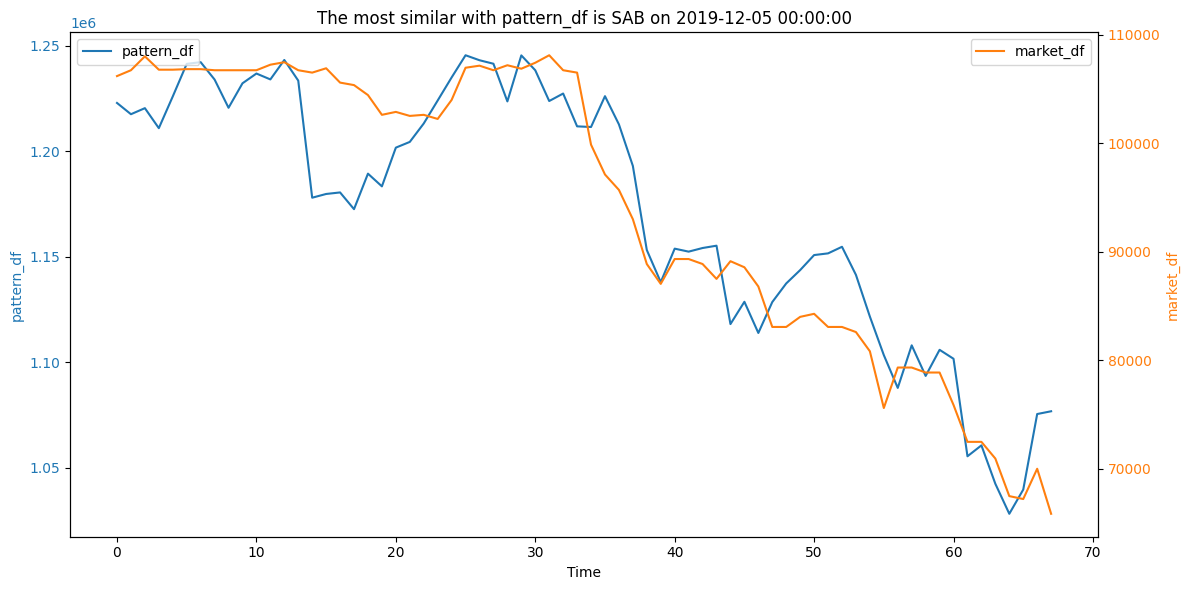

In [39]:
draw_pattern_and_stock(vni_df, df, index)

Find the similar pattern in multi dimension (check  both close and volume)

## find_matching_series_multi_dim_with_date based on close and volume
Let's find pattern in price and volume (price action) in all the stocks, and then filter them out

In [40]:
df = pd.DataFrame()
# Iterate over the company list and add the historical data for each company to the DataFrame
for company in company_list:
    df = pd.concat([df, stock_historical_data(company, "2007-01-01", current_date, "1D", "stock")], axis=0)

# Print the head of the DataFrame
df = convert_data_type(df, time_cols, float_cols, cat_cols)
df.head()

time    open    high     low   close     volume ticker
0 2012-03-20  4930.0  5030.0  4870.0  4970.0   862200.0    ACB
1 2012-03-21  4950.0  5050.0  4890.0  4990.0  1608000.0    ACB
2 2012-03-22  5030.0  5030.0  4910.0  4990.0   578600.0    ACB
3 2012-03-23  4950.0  5000.0  4910.0  4950.0  1402600.0    ACB
4 2012-03-26  5050.0  5060.0  4970.0  4990.0  1228700.0    ACB

In [41]:
def find_matching_series_multi_dim_with_date(stock_data, 
                                             start_date='2023-07-30', end_date='2023-10-15', 
                                             time_col='time', dimension_cols=['close', 'volume'],
                                             nn_idx_threshold=5, distance_threshold = None,
                                             plot=False):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    m = (end_date - start_date).days
    start_date_index = len(stock_data) - m

    df = stock_data[dimension_cols].reset_index(drop = True)
    mps, indices = stumpy.mstump(df, m)
    start_date_index = np.repeat(start_date_index, len(df.columns))
    nn_idx = indices[np.arange(len(df.columns)), start_date_index]
    # Check if the absolute difference between element 1 and element 2 is less than threshold
    if np.abs(nn_idx[1] - nn_idx[0]) > nn_idx_threshold:
        return None, None

    distance = []
    for k in range(len(df.columns)):
        distance.append(mps[k, nn_idx[k]])
    mean_distance = np.mean(distance)

    if distance_threshold is not None and mean_distance > distance_threshold:
        return None, None

    result  = np.concatenate((nn_idx, np.array([mean_distance])))

    print (f'Distance m: {m}')
    print(f'Ticker: {stock_data.iloc[nn_idx[0]].ticker}')
    print(f'From {stock_data.iloc[nn_idx[0]].time} to {stock_data.iloc[nn_idx[0]+m].time}')
    print('nn_idx', nn_idx)

    if plot:
    
        fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14, 3 * mps.shape[0] * 2))

        for k, dim_name in enumerate(df.columns):
            axs[k].set_ylabel(dim_name, fontsize='20')
            axs[k].plot(df[dim_name])
            axs[k].set_xlabel('Time', fontsize ='20')

            axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
            axs[k + mps.shape[0]].plot(mps[k], c='orange')
            axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

            axs[k].axvline(x=start_date_index[1], linestyle="dashed", c='black')
            axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
            axs[k + mps.shape[0]].axvline(x=start_date_index[1], linestyle="dashed", c='black')
            axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

            axs[k].plot(range(start_date_index[k], start_date_index[k] + m), df[dim_name].iloc[start_date_index[k] : start_date_index[k] + m], c='red', linewidth=4)
            axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
            axs[k + mps.shape[0]].plot(start_date_index[k], mps[k, start_date_index[k]] + 1, marker="v", markersize=10, color='red')
            axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')

        plt.tight_layout()
        plt.show()
    return stock_data.iloc[nn_idx[0]].ticker, result 


In [42]:
df.head()

time    open    high     low   close     volume ticker
0 2012-03-20  4930.0  5030.0  4870.0  4970.0   862200.0    ACB
1 2012-03-21  4950.0  5050.0  4890.0  4990.0  1608000.0    ACB
2 2012-03-22  5030.0  5030.0  4910.0  4990.0   578600.0    ACB
3 2012-03-23  4950.0  5000.0  4910.0  4950.0  1402600.0    ACB
4 2012-03-26  5050.0  5060.0  4970.0  4990.0  1228700.0    ACB

In [43]:
current_date

'2023-11-04'

In [44]:
df[df.ticker == 'GVR'].tail()

time     open     high      low    close     volume ticker
1399 2023-10-30  19300.0  19300.0  18000.0  18000.0  2345000.0    GVR
1400 2023-10-31  18200.0  18200.0  16850.0  16900.0  2313300.0    GVR
1401 2023-11-01  16900.0  17400.0  16450.0  17300.0  1479400.0    GVR
1402 2023-11-02  17550.0  18500.0  17550.0  18500.0  2148500.0    GVR
1403 2023-11-03  18650.0  18700.0  18200.0  18500.0  1245300.0    GVR

Distance m: 97
Ticker: ACB
From 2012-11-20 00:00:00 to 2013-04-15 00:00:00
nn_idx [171 171]


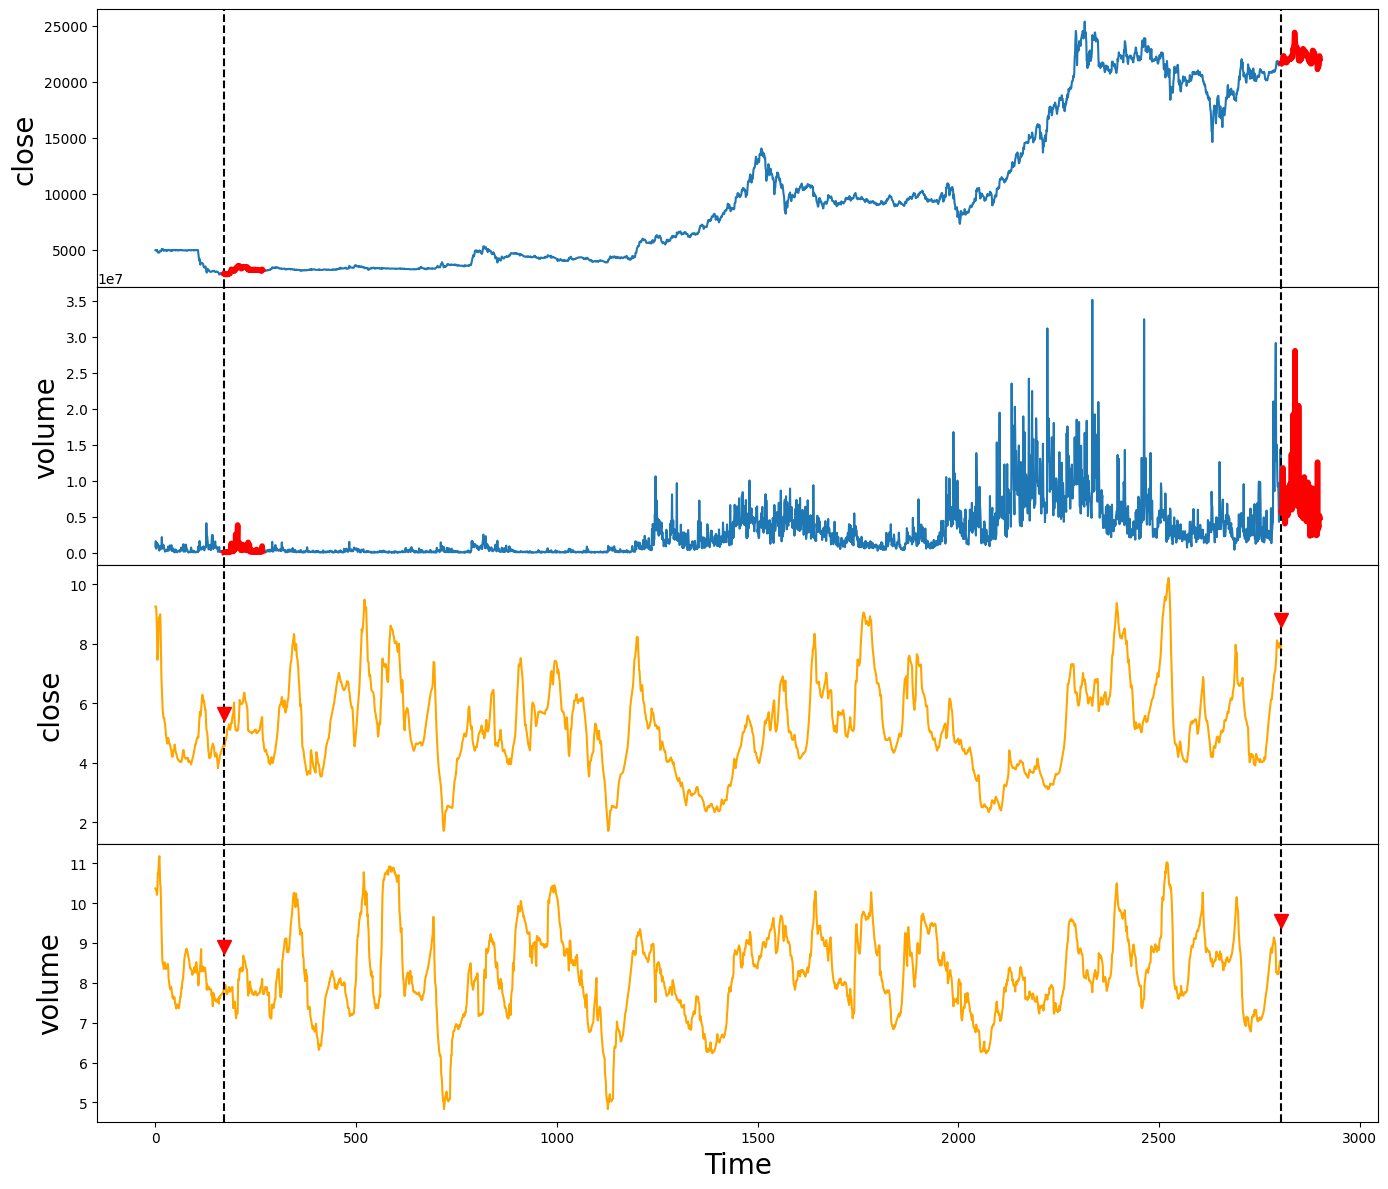

Distance m: 97
Ticker: BCM
From 2018-04-09 00:00:00 to 2018-08-27 00:00:00
nn_idx [33 35]


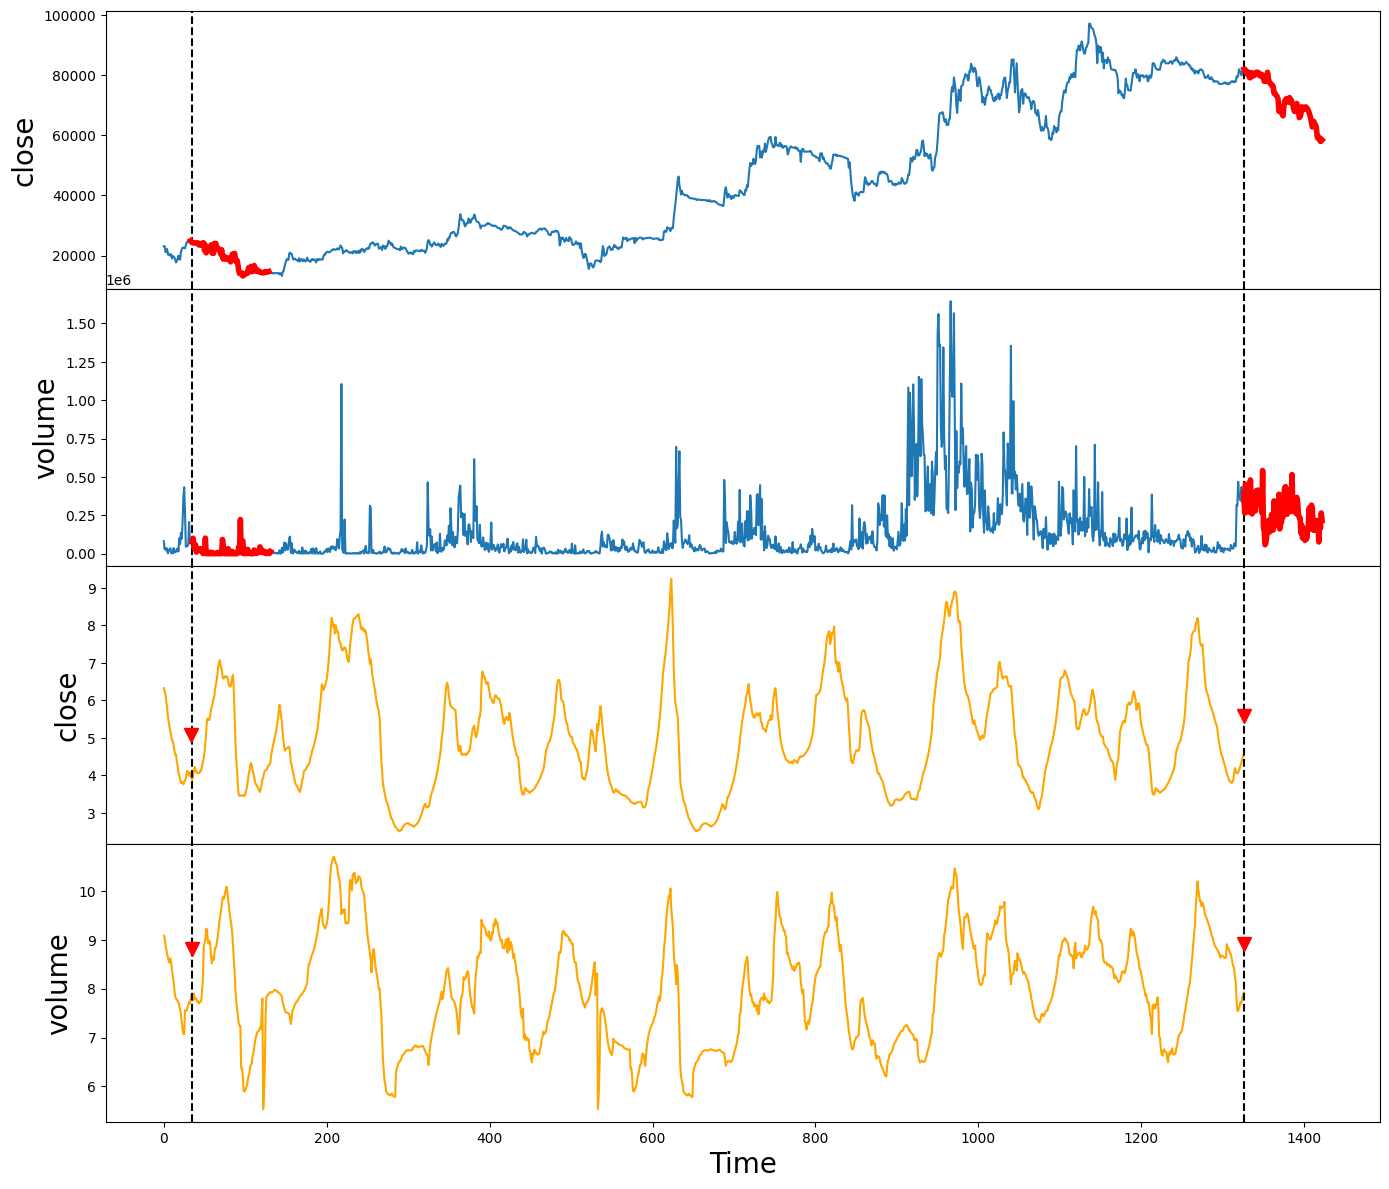

Distance m: 97
Ticker: DXG
From 2013-12-31 00:00:00 to 2014-06-02 00:00:00
nn_idx [449 448]


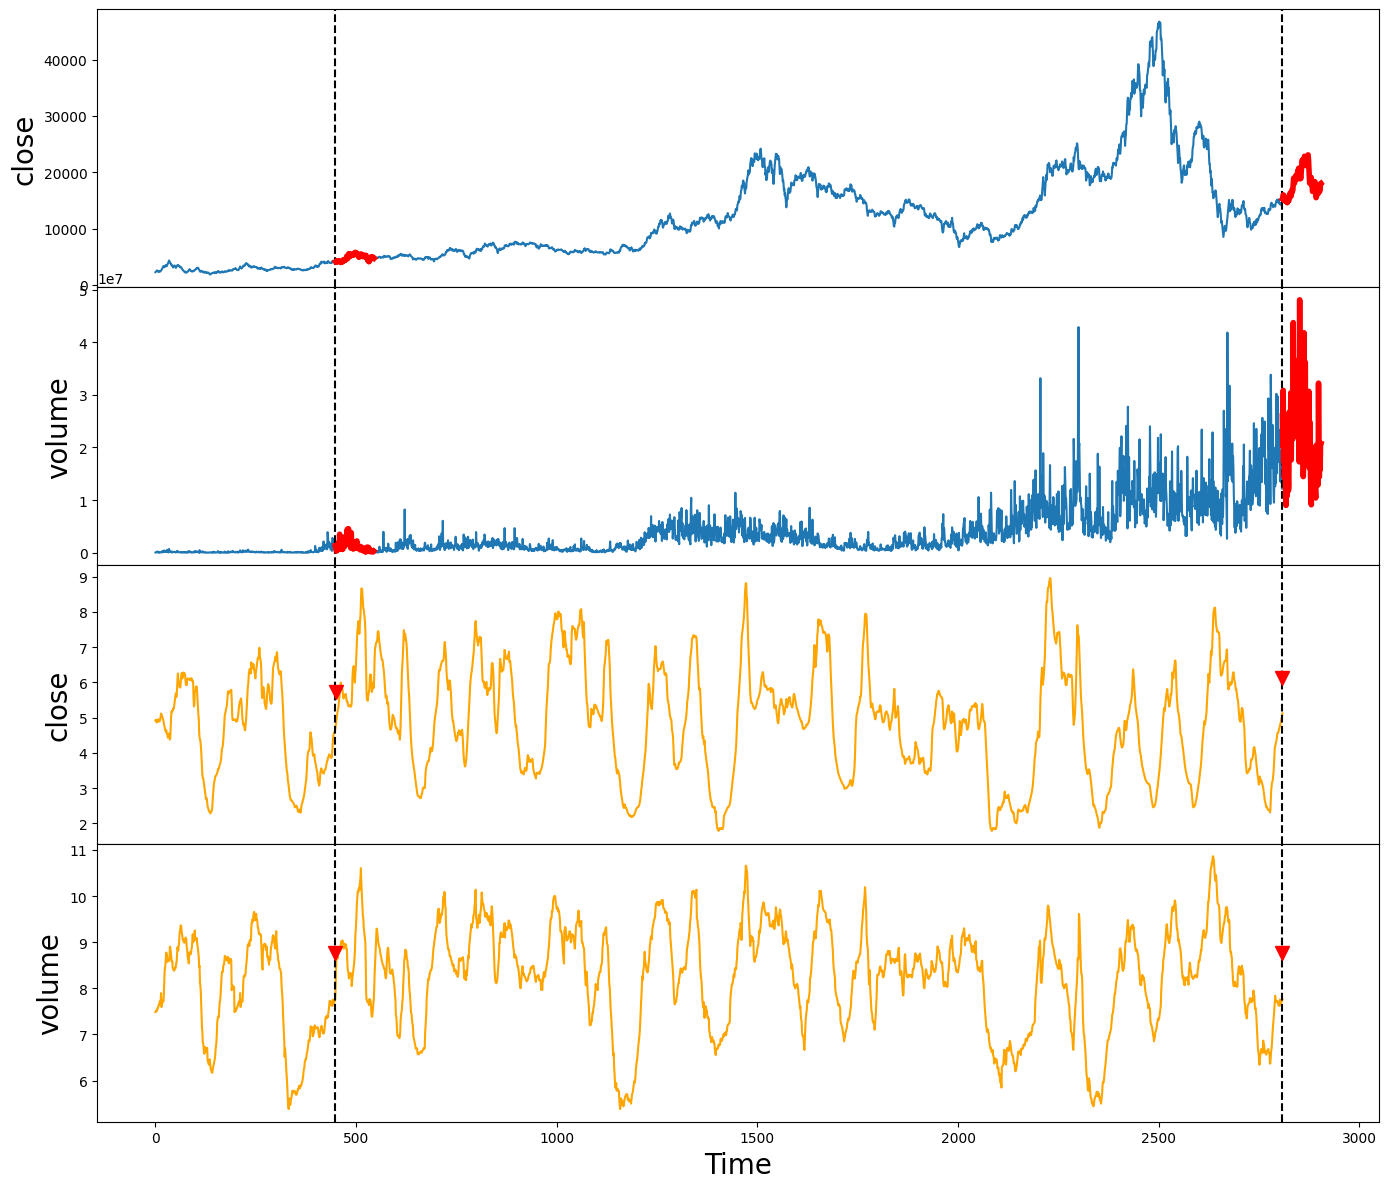

Distance m: 97
Ticker: EIB
From 2021-04-08 00:00:00 to 2021-08-26 00:00:00
nn_idx [2259 2260]


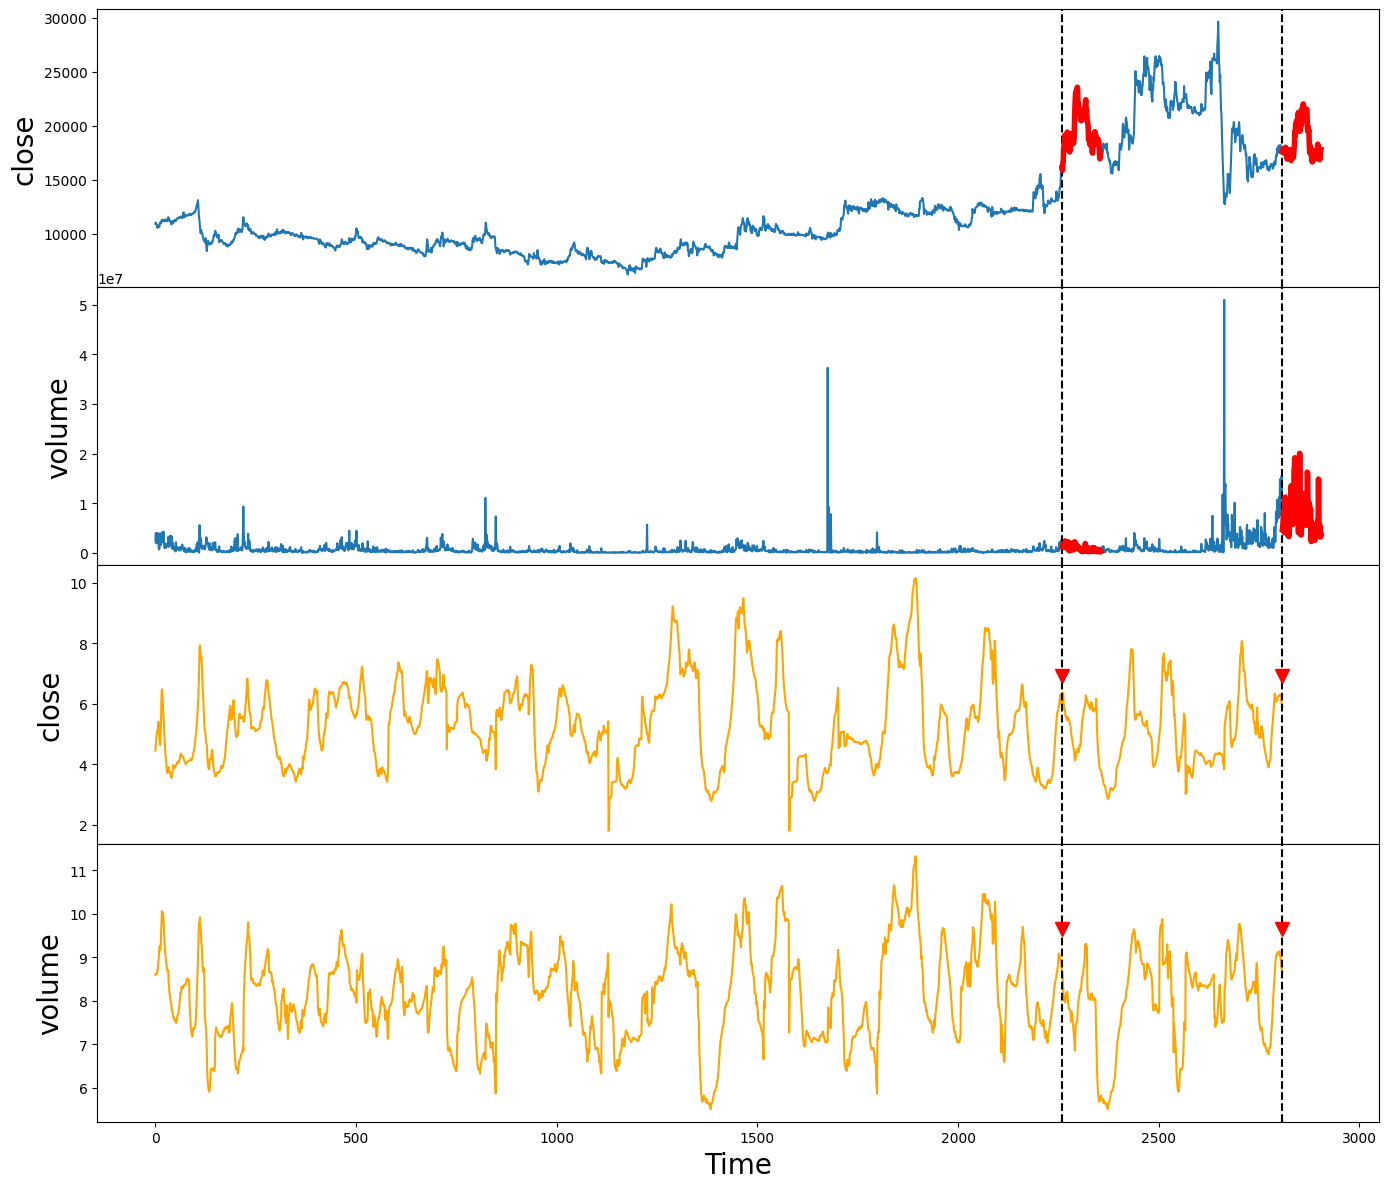

Distance m: 97
Ticker: HCM
From 2018-01-03 00:00:00 to 2018-06-01 00:00:00
nn_idx [1447 1450]


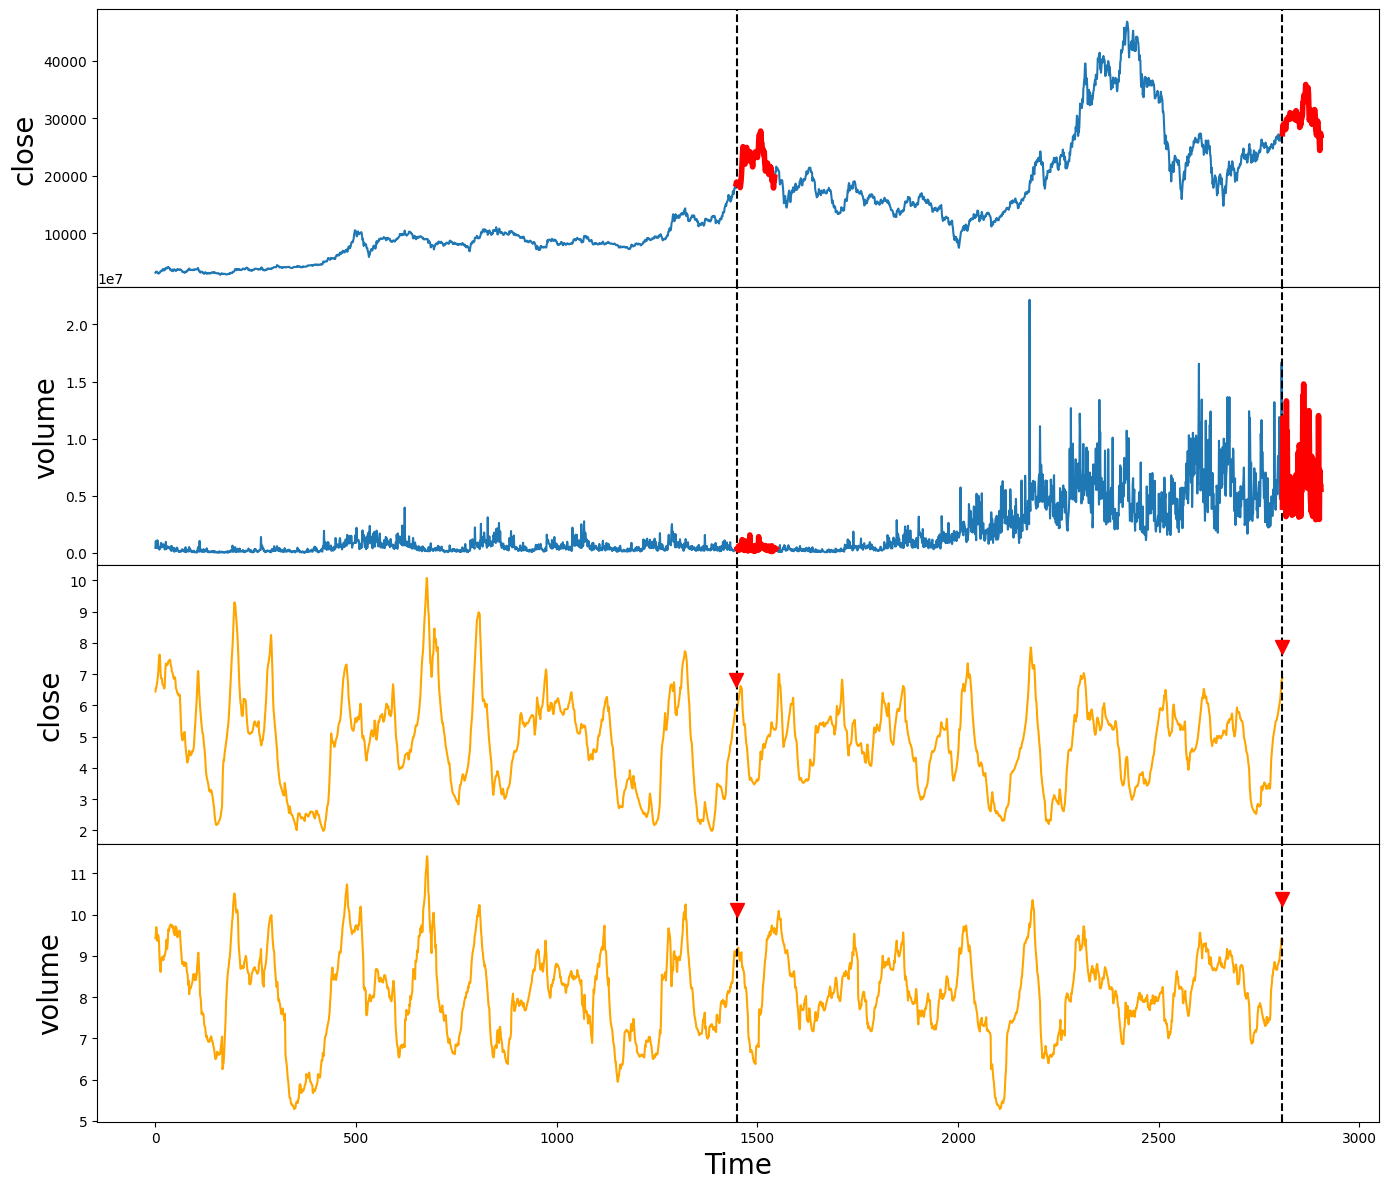

Distance m: 97
Ticker: HDB
From 2020-08-20 00:00:00 to 2021-01-06 00:00:00
nn_idx [652 652]


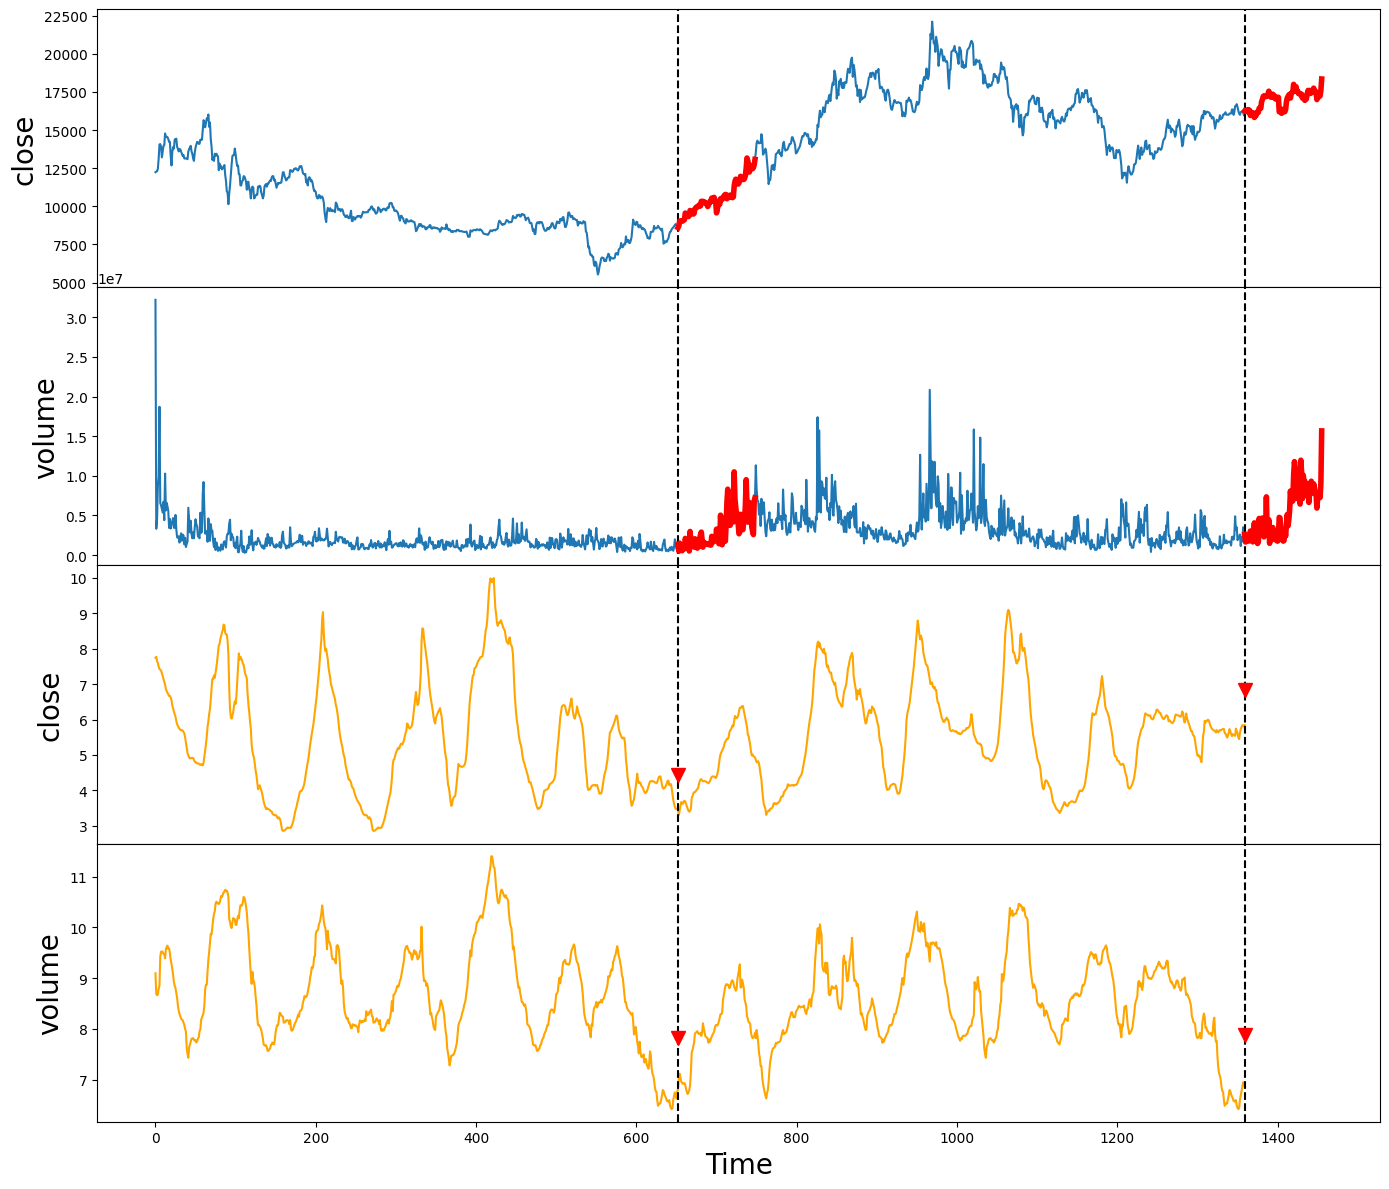

Distance m: 97
Ticker: KBC
From 2016-07-06 00:00:00 to 2016-11-21 00:00:00
nn_idx [1069 1070]


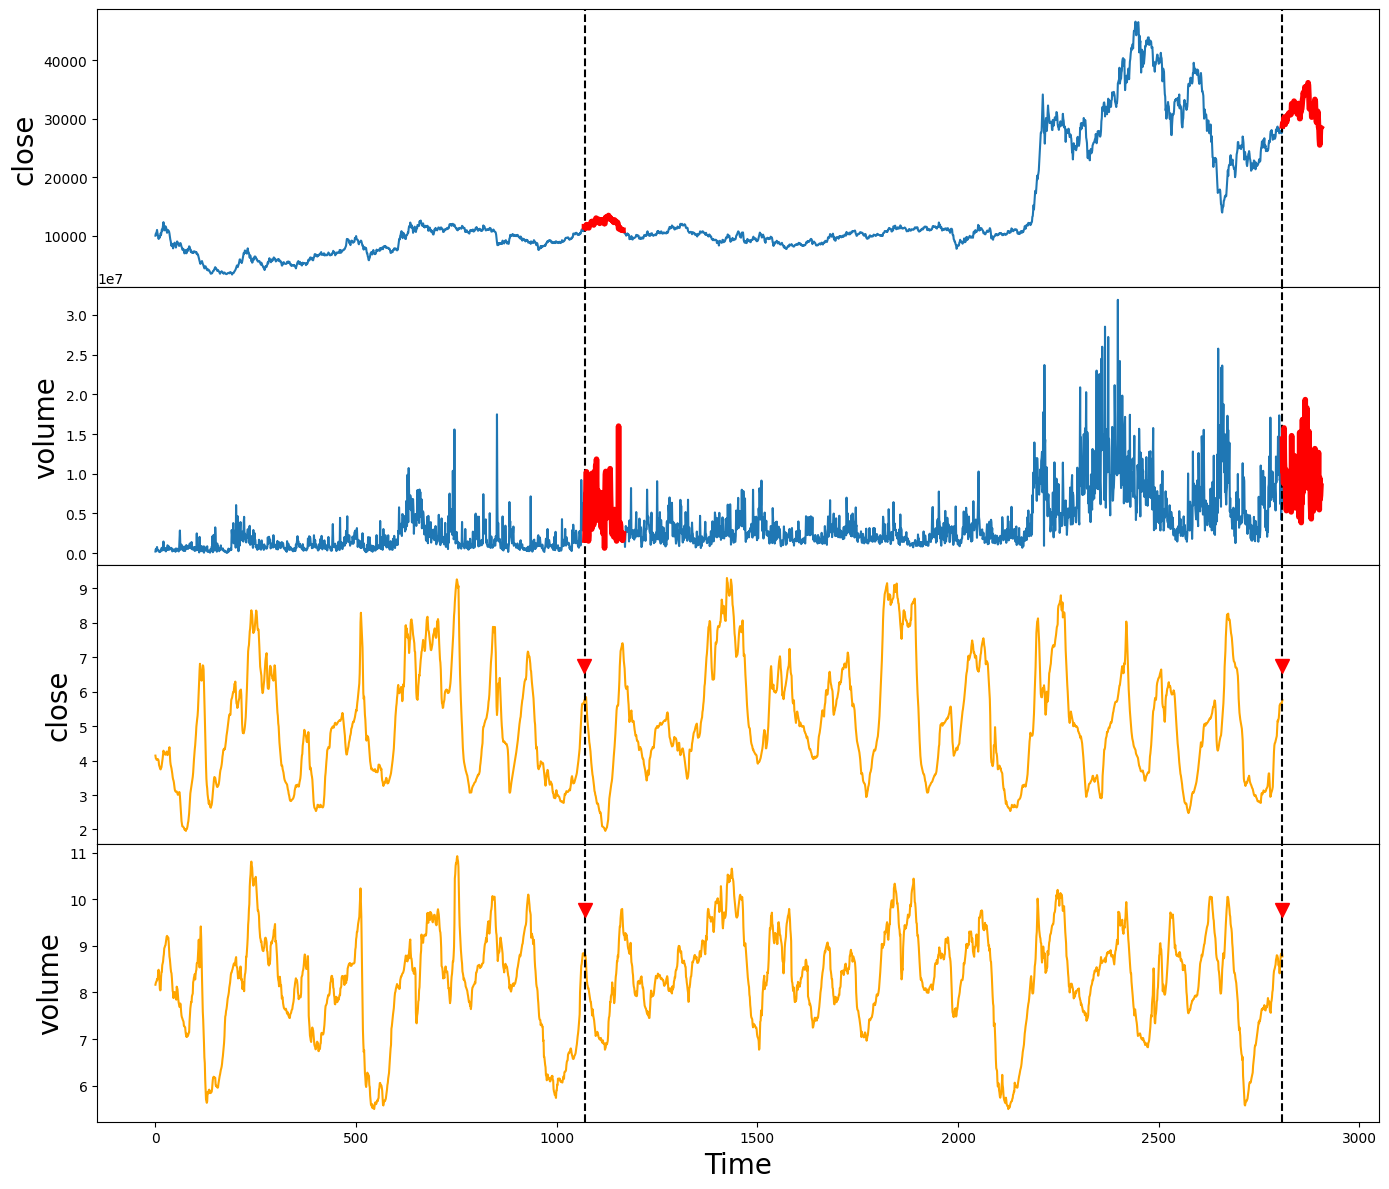

Distance m: 97
Ticker: KDH
From 2016-08-16 00:00:00 to 2016-12-30 00:00:00
nn_idx [1098 1099]


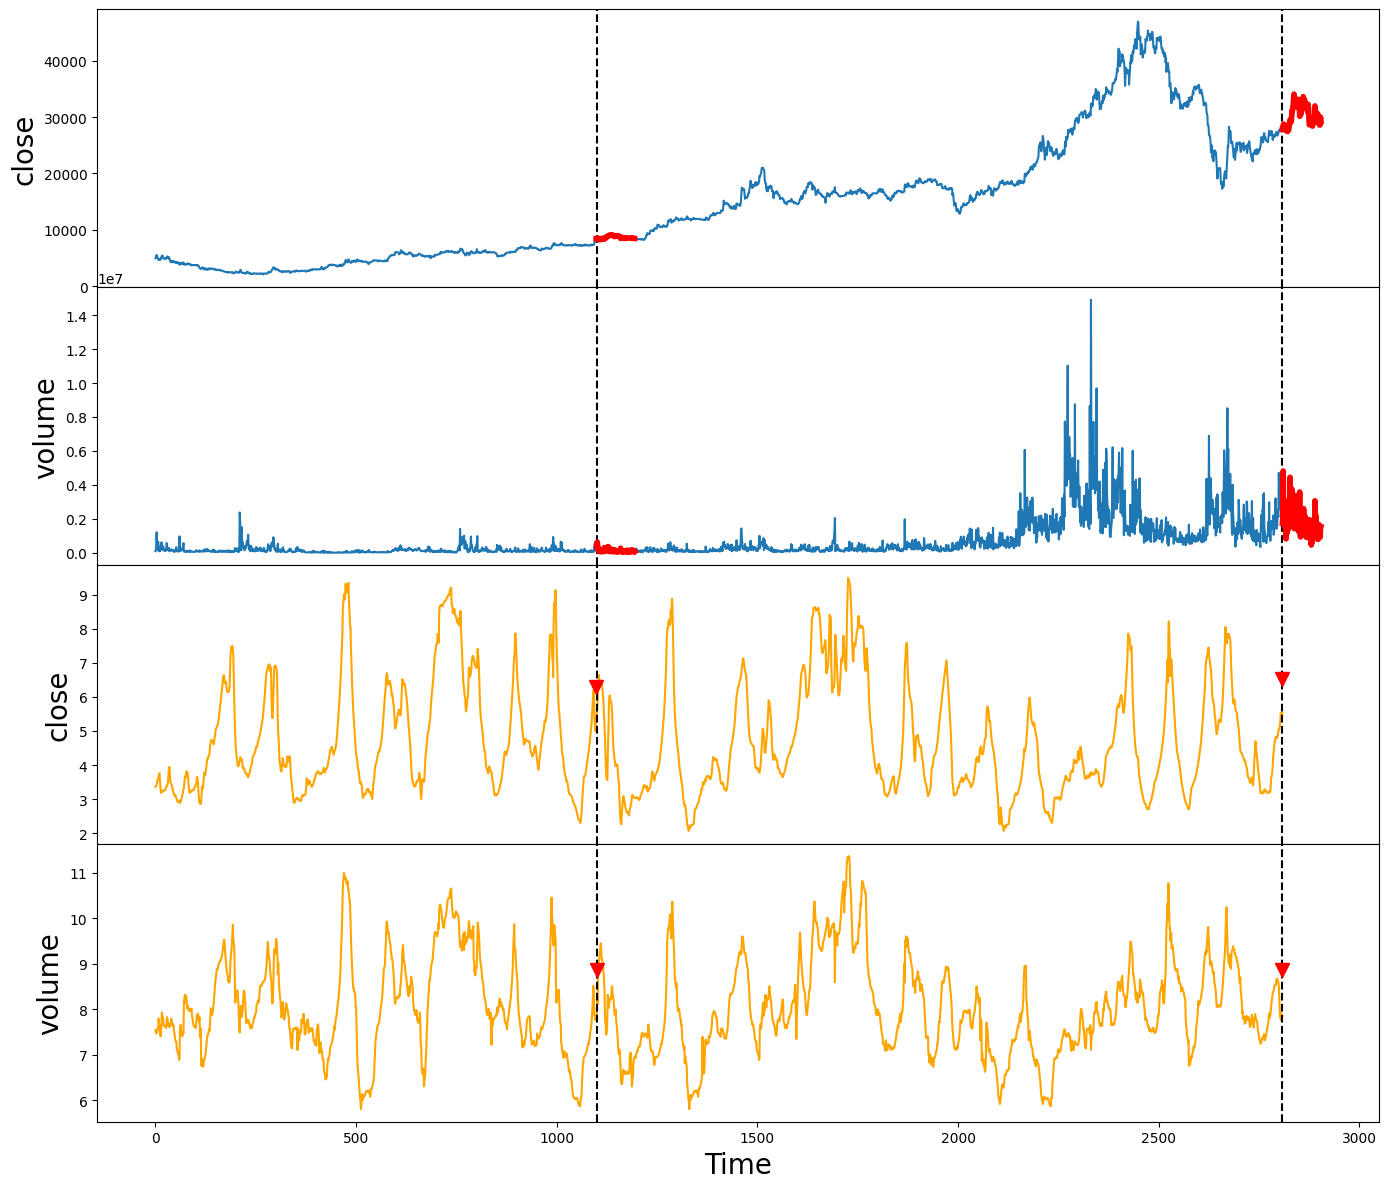

Distance m: 97
Ticker: PVD
From 2019-01-10 00:00:00 to 2019-06-07 00:00:00
nn_idx [1700 1702]


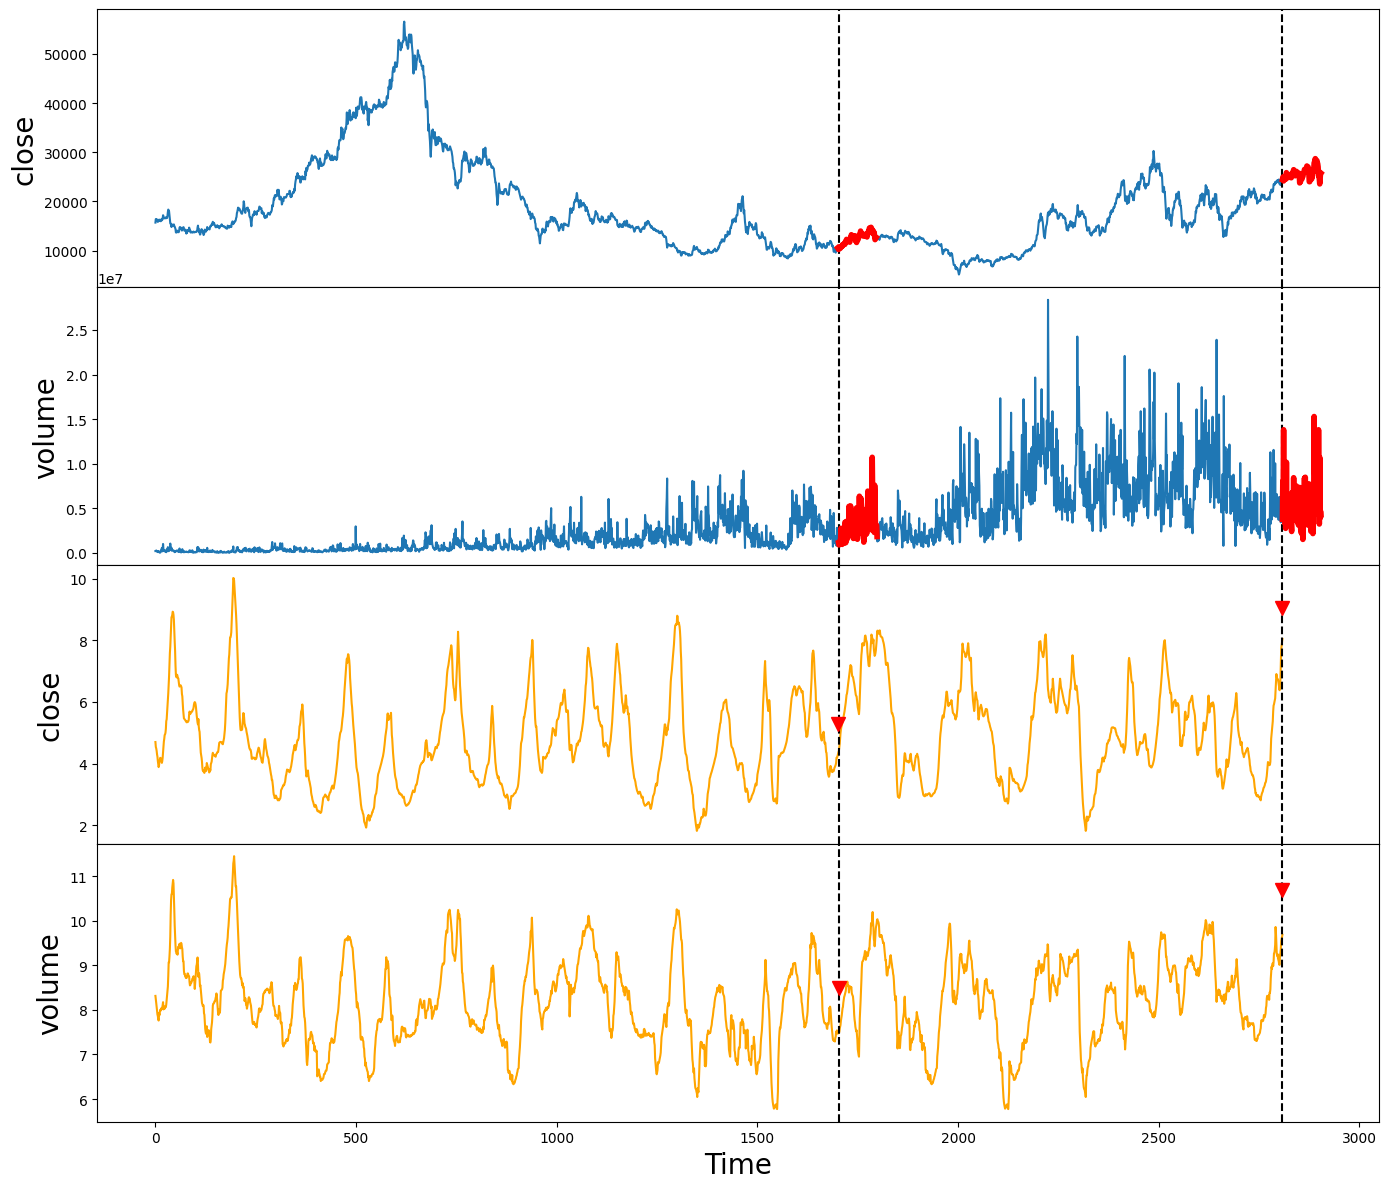

Distance m: 97
Ticker: SSB
From 2022-02-08 00:00:00 to 2022-06-28 00:00:00
nn_idx [218 222]


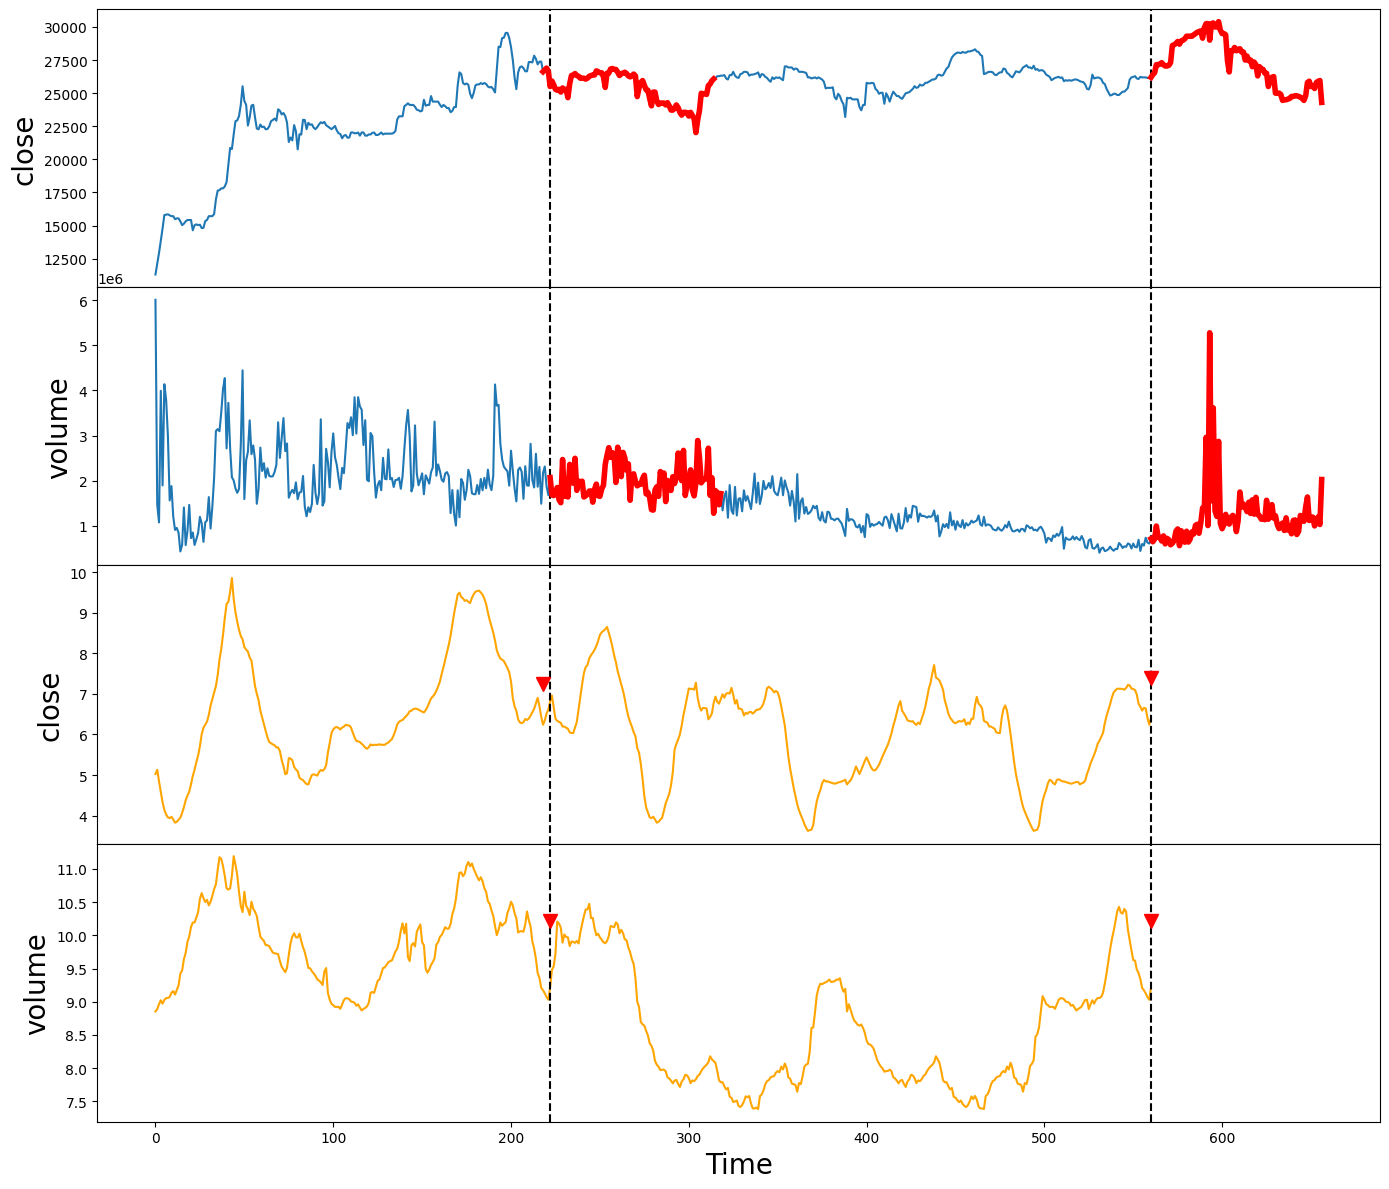

Distance m: 97
Ticker: VCG
From 2013-12-26 00:00:00 to 2014-05-28 00:00:00
nn_idx [446 447]


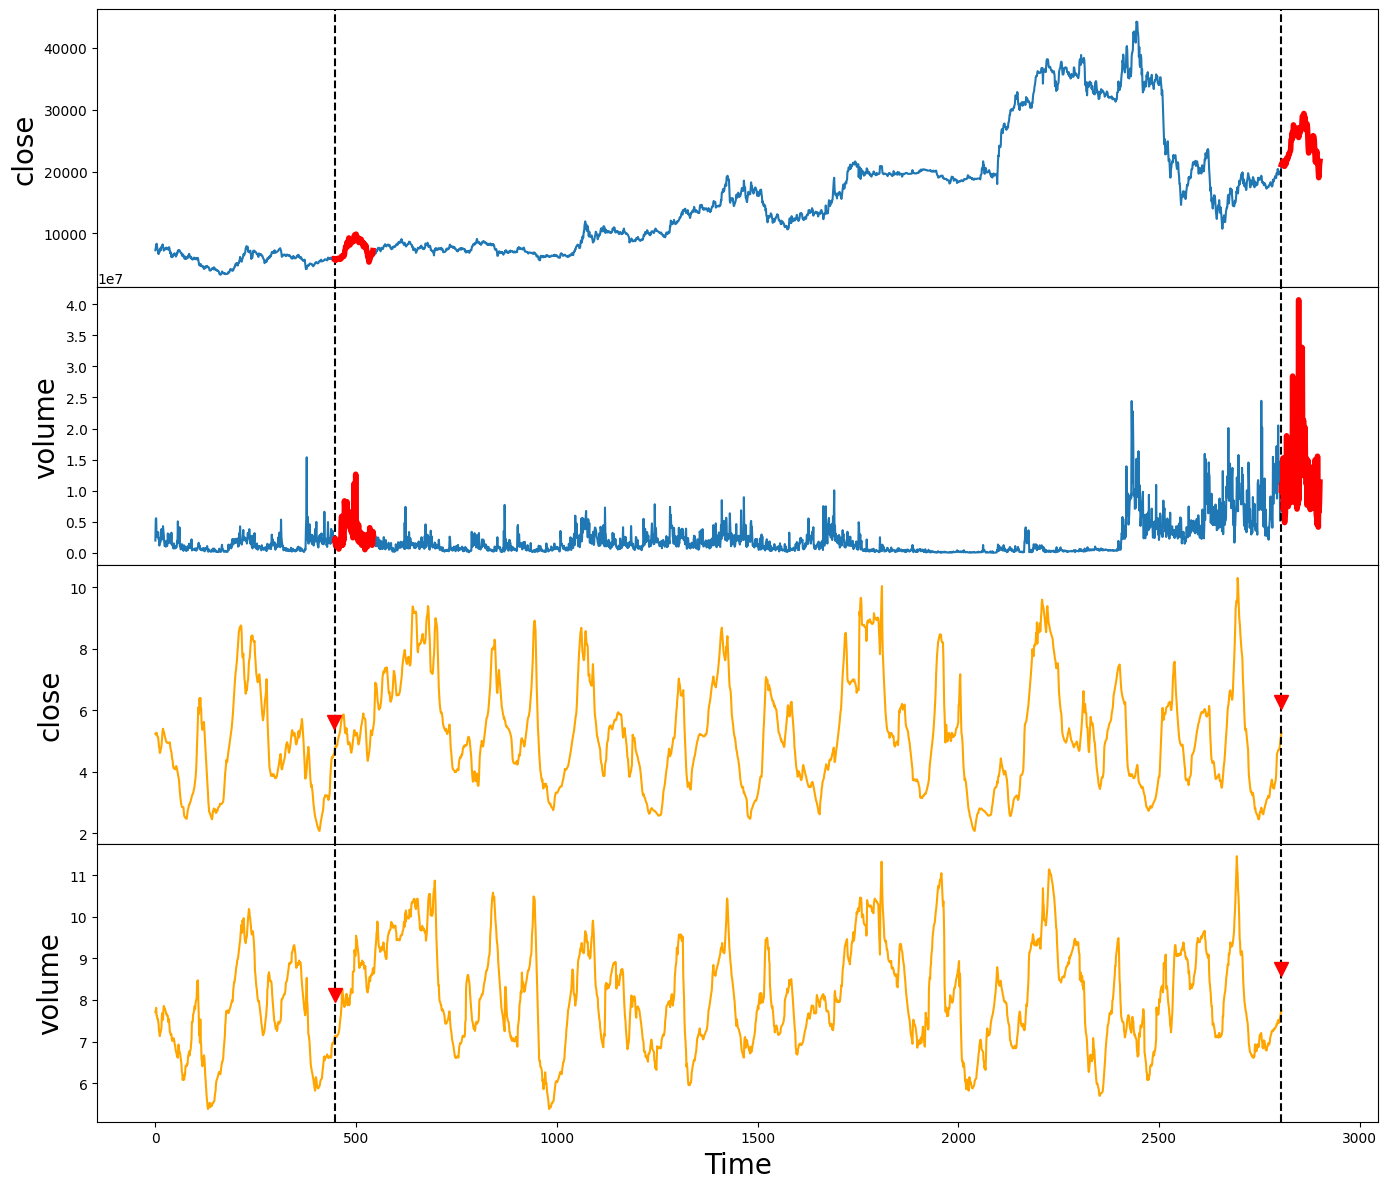

Distance m: 97
Ticker: VIB
From 2021-12-29 00:00:00 to 2022-05-26 00:00:00
nn_idx [1238 1239]


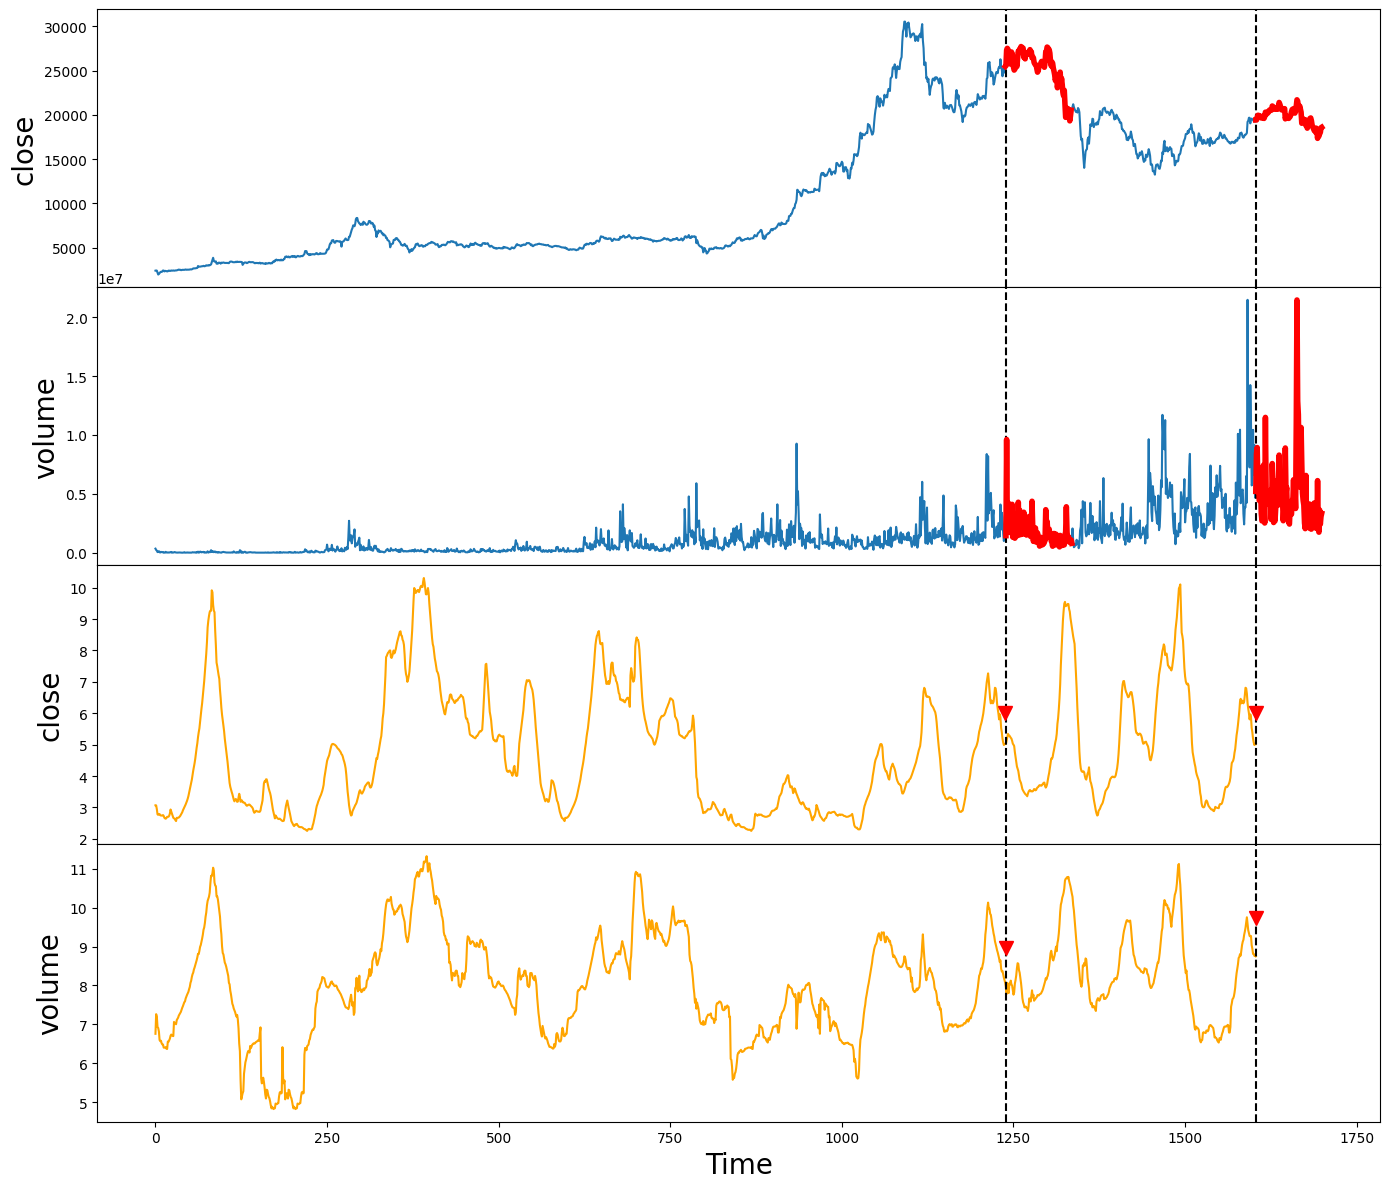

Distance m: 97
Ticker: VND
From 2018-01-08 00:00:00 to 2018-06-06 00:00:00
nn_idx [1446 1449]


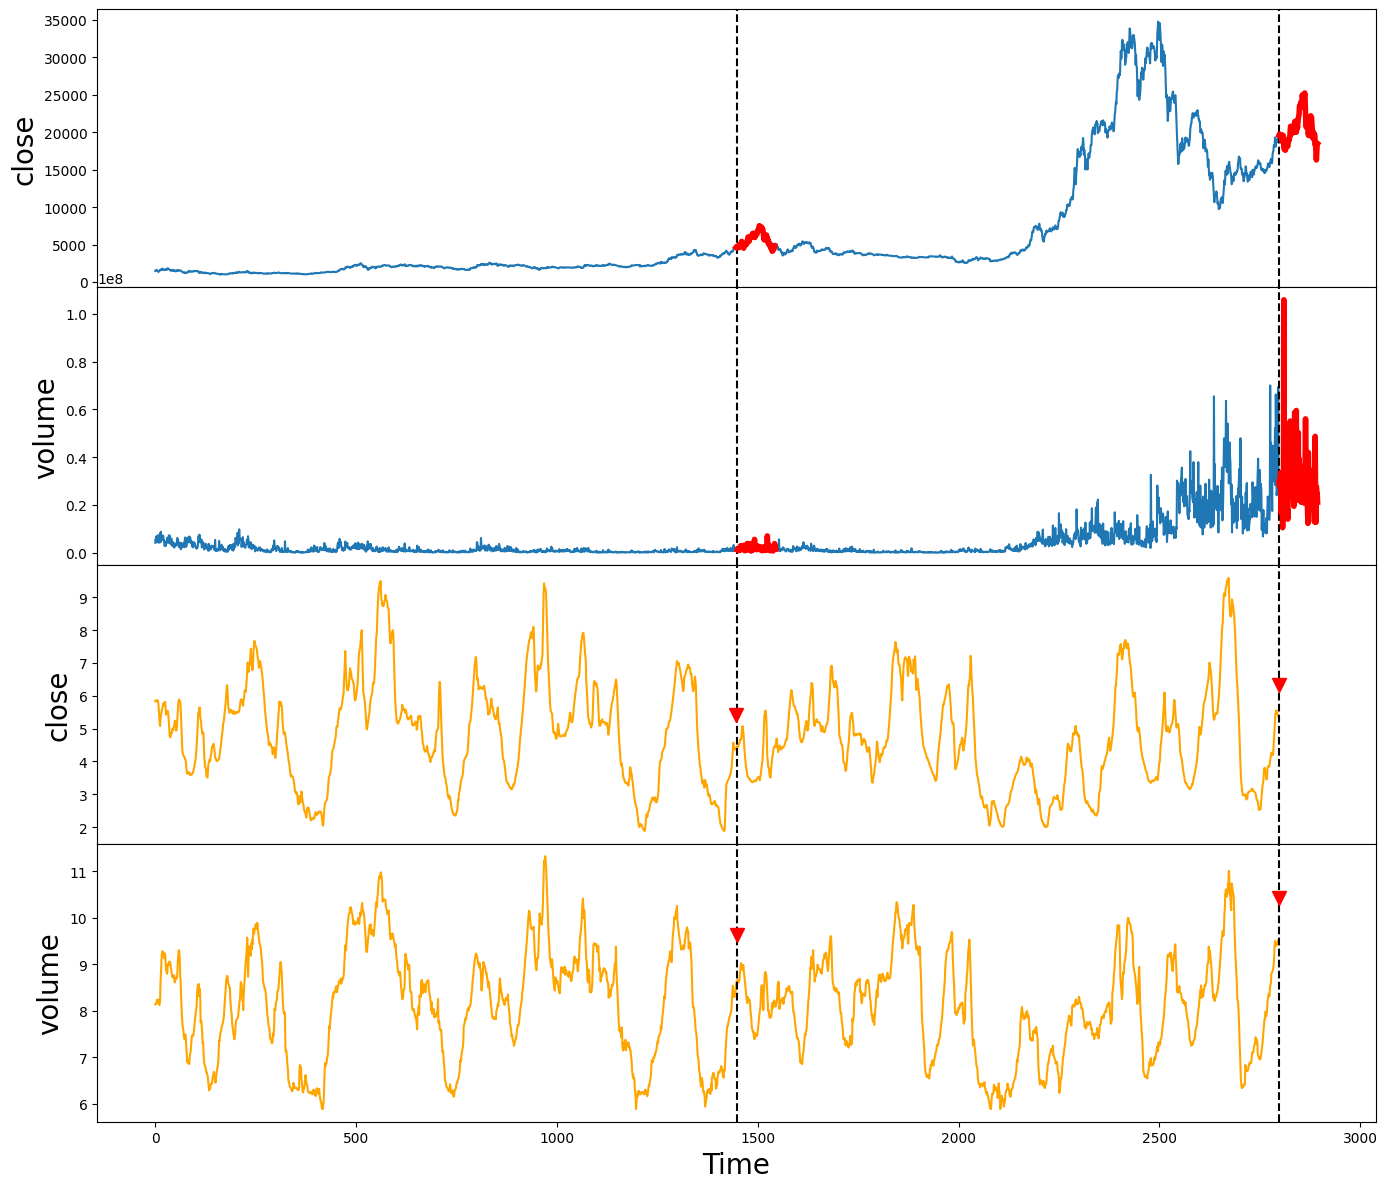

In [45]:
unique_tickers = df['ticker'].unique()
results_dict = {}  # Initialize an empty dictionary to store results

for ticker in unique_tickers:
    # Extract data for the current ticker
    stock_data = df[df['ticker'] == ticker]
    
    # Call the function for the current ticker
    stock_name, result = find_matching_series_multi_dim_with_date(stock_data, start_date='2023-07-30', end_date=current_date, 
                                                                  time_col='time', dimension_cols=['close', 'volume'], 
                                                                  plot = True)
    
    # Check if the stock_name is not None
    if stock_name is not None:
        # Add the result to the dictionary with stock_name as the key
        results_dict[stock_name] = result

In [46]:
results_dict

{'ACB': array([171.        , 171.        ,   6.26385771]),
 'BCM': array([33.        , 35.        ,  5.94048084]),
 'DXG': array([449.        , 448.        ,   6.24979232]),
 'EIB': array([2259.       , 2260.       ,    7.2878221]),
 'HCM': array([1447.       , 1450.       ,    7.4581121]),
 'HDB': array([652.        , 652.        ,   5.12822969]),
 'KBC': array([1069.       , 1070.       ,    7.2625864]),
 'KDH': array([1098.        , 1099.        ,    6.56719762]),
 'PVD': array([1700.        , 1702.        ,    5.88061457]),
 'SSB': array([218.        , 222.        ,   7.72992561]),
 'VCG': array([446.        , 447.        ,   5.87104419]),
 'VIB': array([1238.        , 1239.        ,    6.48416906]),
 'VND': array([1446.        , 1449.        ,    6.52281395])}